# Table of Contents

* [Introduction](#Introduction)
* [Analysis](#Analysis)
* [Report](#Report)

# Introduction

Author: Alan Lorenzetti  
Date: 02/01/2023  

In this analysis, I will explore SVA properties obtained from Supplemental_Table_S1 (SVA annotation) by [van Bree et al. (2022)](https://pubmed.ncbi.nlm.nih.gov/35332097/). I will also determine repeats (simple tandem repeats, STR) at the five prime end of SVAs using TRF and classify SVAs regarding their localization relative to genes. Further, I will perform overrepresentation analysis of categorical variables taking into consideration additional features, such as transcription starting at the 5' end.

# Analysis

In [1]:
# 20230201 alorenzetti

# description ####
# This script will take SVAs
# and compute general stats
# it will also generate plots
# for many combinations of features

# setting up ####
# loading libs
packs = c(
 "tidyverse",
 "ggpubr",
 "ggthemes",
 "svglite",
 "viridis",
 "Biostrings",
 "BSgenome",
 "rtracklayer",
 "ggbeeswarm",
 "ggrepel",
 "ComplexHeatmap",
 "circlize",
 "MASS"
)

# multivariate plots
# maybe I will remove this later
# packs = c(packs, 
#           "easyalluvial",
#           "sunburstR",
#           "d3r",
#           "htmltools")

lapply(packs, require, character.only = TRUE)

theme_set(theme_pubr())

# setting working directory relative to _h
setwd("../_m/")

# setting up path
# matching the bin
# in the conda env
# this is necessary
# for R finding
# the trf program
conda_env = str_replace(Sys.getenv("R_HOME"), "^.*/(.*)/lib/R$", "\\1")
home = str_replace(Sys.getenv("R_HOME"), "^(.*)/.*/lib/R$", "\\1")
conda_env_path = paste0(home, "/", conda_env, "/bin")
old_path = Sys.getenv("PATH")
Sys.setenv(PATH = paste(old_path, conda_env_path, sep = ":"))

# adjusting tableau color scheme pal
tableau10_col_blind_bckp = ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][["regular"]][["Color Blind"]]
tableau10_col_blind_mod = tableau10_col_blind_bckp
tableau10_col_blind_mod[1:10,] = tableau10_col_blind_bckp[c(7,9,3,4,5,10,8,1,2,6),]
# scales::show_col(tableau10_col_blind_mod$value)
# scales::show_col(tableau10_col_blind_bckp$value)

ggthemes_data[["tableau"]][["color-palettes"]][["regular"]][["Color Blind"]] = tableau10_col_blind_mod

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggpubr

Loading required package: ggthemes

Loading required package: svglite

Loading required package: viridis

Loading required package: viridisLite

Loading required package: Biostrings

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.fram

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

In [2]:
# getting started ####
# i gotta modify this function to allow a
# modified palette in ggthemes
# it is basecally changing where it gets the
# palettes from (see commented for original)
custom_tableau_color_pal = function (palette = "Tableau 10", type = c("regular", "ordered-sequential", 
    "ordered-diverging"), direction = 1) 
{
    type <- match.arg(type)
    # palettes <- ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][[type]]
    palettes <- ggthemes_data[["tableau"]][["color-palettes"]][[type]]
    if (!palette %in% names(palettes)) {
        stop("`palette` must be one of ", paste(names(palettes), 
            collapse = ", "), ".")
    }
    values <- palettes[[palette]][["value"]]
    max_n <- length(values)
    f <- function(n) {
        check_pal_n(n, max_n)
        values <- values[seq_len(n)]
        if (direction < 0) {
            values <- rev(values)
        }
        values
    }
    attr(f, "max_n") <- length(values)
    f
}

environment(custom_tableau_color_pal) = asNamespace('ggthemes')
assignInNamespace("tableau_color_pal", custom_tableau_color_pal, ns = "ggthemes")

In [3]:
# this function will link the genome
# in the analysis directory
link_read_genome = function(genome_path = genome_path,
                            chop_acc = chop_acc) {
    
    # file name current dir
    filenameHere = str_replace(genome_path, "^.*/(.*)$", "\\1")
    
    # linking genome in the analysis dir
    if(!file.exists(filenameHere)){
        file.symlink(from = genome_path, to = ".")
    }
    
    # reading genome
    genome = readDNAStringSet(filepath = filenameHere, format = "fasta")
    
    if(chop_acc == T){
        names(genome) = str_replace(names(genome), "^(.*?) .*$", "\\1")
    }
    
    return(genome)
}

In [4]:
# this function will link the genome annotation
# in the analysis directory
link_read_genome_annot = function(genome_annot_path = genome_annot_path) {
    
    # file name current dir
    filenameHere = str_replace(genome_annot_path, "^.*/(.*)$", "\\1")
    
    # linking genome annot in the analysis dir
    if(!file.exists(filenameHere)){
        file.symlink(from = genome_annot_path, to = ".")
    }
    
    # reading genome annot
    genome_annot = rtracklayer::import(con = filenameHere,
                                       format = "gtf")
    names(genome_annot) = mcols(genome_annot)$gene_id
    
    return(genome_annot)
}

In [5]:
# this function will extract sequences
# using a gr object and a genome
extract_seq = function(genome = genome,
                       gr = gr,
                       fastaOutName = fastaOutName) {
    
    # getting seqs
    seqs = getSeq(genome, gr)
    
    # saving them in current dir
    writeXStringSet(x = seqs, filepath = fastaOutName, format = "fasta")
    
    return(seqs)
}

In [6]:
# this function will run TRF
run_trf = function(fastafile = fastafile,
                   outputfile = outputfile,
                   matchscore = matchscore,
                   mismatchpenalty = mismatchpenalty,
                   indelpenalty = indelpenalty,
                   minscore = minscore,
                   maxperiod = maxperiod) {
    
    prog = "trf"
    args = c(fastafile, 2, 7, 7, 80, 10, 50, 500, "-h", "-f", "-d", "-ngs")
    args[2] = matchscore
    args[3] = mismatchpenalty
    args[4] = indelpenalty
    args[7] = minscore
    args[8] = maxperiod
    
    system2(command = prog, 
            args = args,
            stdout = outputfile)
}

In [7]:
# this function will parse TRF output (-ngs)
parse_trf = function(filename = filename, genomebuild = genomebuild){
    
    # TRF output follow this structure:
    # @header seq1
    # tsv result1 seq1
    # tsv result2 seq1
    # let us get a list of tsv results for each seq
    
    # getting started
    output = tibble()
    con = file(filename, "r")
    while ( TRUE ) {
        line = readLines(con, n = 1)
        if ( length(line) == 0 ) {
          break
        }
        if(str_starts(line, "@")){
            header=str_replace(line, "^@(.*?) .*$", "\\1")
        }
        if(!str_starts(line, "@")){
            row = str_split_fixed(string = line, pattern = " ", n = 17) %>%
                as_tibble() %>% 
                mutate(V18 = header,
                       V19 = genomebuild)
            output = bind_rows(output, row)
        }
    }
    close(con)
    
    # setting up the trf column names
    # taken from 
    # https://blaxter-lab-documentation.readthedocs.io/en/latest/trf.html
    # cols 1+2:  Indices of the repeat relative to the start of the sequence
    # col 3:     Period size of the repeat
    # col 4:     Number of copies aligned with the consensus pattern
    # col 5:     Size of consensus pattern (may differ slightly from the period size)
    # col 6:     Percent of matches between adjacent copies overall
    # col 7:     Percent of indels between adjacent copies overall
    # col 8:     Alignment score
    # cols 9-12: Percent composition for each of the four nucleotides
    # col 13:    Entropy measure based on percent composition
    # col 14:    Consensus sequence
    # col 15:    Repeat sequence
    trfcols = c("repeat_start",
                "repeat_end",
                "period_size",
                "number_of_copies",
                "repeat_size",
                "pct_matches",
                "pct_indels",
                "aln_score",
                "pct_composition_A",
                "pct_composition_C",
                "pct_composition_G",
                "pct_composition_T",
                "entropy",
                "consensus_seq",
                "repeat_seq",
                "left_flank",
                "right_flank",
                "seq_id",
                "genome_build")
    
    colnames(output) = trfcols
    
    output = output %>% 
        relocate(seq_id) %>%
        mutate(across(.cols = c(
                                repeat_start, repeat_end,
                                period_size, number_of_copies,
                                repeat_size, pct_matches,
                                pct_indels, aln_score,
                                pct_composition_A, pct_composition_C,
                                pct_composition_G, pct_composition_T,
                                entropy),
                      .fns = ~ as.numeric(.x))) %>% 
        mutate(seq_id = str_replace(seq_id, "^@", ""),
               trf_id = paste0(seq_id, ":trf", 1:dim(.)[1]))
    
    return(output)
    
}

In [8]:
# this function is a helper for summarise
# function used to filter trf outut
# this will filter motifs in our preference
# list and then find the longest;
# if STRs do not match our favorite STRs
# it is going to return the longest
find_idx_longer = function(x = x,
                           motifs = motifs,
                           target_motifs = target_motifs) {
    
    # checking which and how many
    # motifs match our targets
    matching_motifs = motifs %in% target_motifs
    matching_n = sum(matching_motifs)
    
    # filtering 
    if(matching_n == 0){
        return(order(x, decreasing = T)[1])
    } else if(matching_n == 1){
        return(which(matching_motifs))
    } else if(matching_n > 1){
        return(which(matching_motifs & x == max(x))[1])
    }
}

In [9]:
# this function will generate
# multiple permutations of a sequence
# given a motif
# the algorithm idea was taken from 
# https://www.geeksforgeeks.org/generate-cyclic-permutations-number/
seq_cyclic_permuts = function(motif = motif){
    motif = as.character(motif)
    motifvec = unlist(str_split(motif, pattern = ""))
    n = str_count(motif)
    N = as.numeric(paste0(1:n, collapse = ""))
    num = N
    
    permuts = list()
    while(TRUE){
        permuts = c(permuts, num)
        
        rem = num %% 10
        div = floor(num/10)
        num = (10^(n-1) * rem) + div
        
        if(num == N){break}
    }
    
    indexes = lapply(permuts, str_split, pattern = "")
    indexes = lapply(indexes, unlist)
    indexes = lapply(indexes, as.numeric)
    
    outputList = list()
    for(i in 1:length(indexes)){
        outputList[[i]] = paste0(motifvec[indexes[[i]]], collapse = "")
    }
    
    return(unlist(outputList))
}

In [10]:
# this function will combine
# the previous functions to
# generate a set of motifs
get_motifs = function(motifvec = motifvec,
                      revcomp = revcomp) {
    
    motifs = list()
    for(i in motifvec){
        motifs[[i]] = seq_cyclic_permuts(motif = i)
    }
    motifs = motifs %>% unlist(use.names = F)
    
    if(revcomp == TRUE){
        motifs = rev_comp(motifs)
    }
    
    return(motifs)
}

In [11]:
# this function will
# reverse complement
# sequences given as
# character vector
rev_comp = function(seqs = seqs){
    idx = which(!is.na(seqs))
    
    seqsstringset = DNAStringSet(x = seqs[idx])
    revcompseqs = reverseComplement(x = seqsstringset)
    
    revcompoutput = rep(NA_character_, length(seqs))
    revcompoutput[idx] = revcompseqs
    
    return(revcompoutput)
}

In [12]:
# this function will annotate
# an sva genomic ranges object
# with positions relative
# to genes
annotate_relative_to_genes = function(svaGR = svaGR,
                                      geneGR = geneGR,
                                      txGR = txGR) {

    # getting UTR
    utrGR = txGR[txGR$type == "UTR"]
    
    # getting exons
    exGR = txGR[txGR$type == "exon"]
    
    # inverting strand
    # of genes
    inv_geneGR = invertStrand(geneGR)
    
    # finding overlaps between xx nt
    # upstream to SVAs and simple repeats
    ovlps = list()
    ovlps$sense = findOverlaps(query = svaGR,
                               subject = geneGR,
                               minoverlap = 1) %>% 
        as_tibble()
    ovlps$antisense = findOverlaps(query = svaGR,
                                   subject = inv_geneGR,
                                   minoverlap = 1) %>% 
        as_tibble()
    ovlps$utr = findOverlaps(query = svaGR, 
                             subject = utrGR,
                             ignore.strand = T,
                             minoverlap = 1) %>% 
        as_tibble()
    ovlps$ex = findOverlaps(query = svaGR, 
                            subject = exGR,
                            ignore.strand = T,
                            minoverlap = 1) %>% 
        as_tibble()
    
    
    ovlps$sense_tib = tibble(sva_id = names(svaGR)[ovlps$sense$queryHits],
                             sense_to = names(geneGR)[ovlps$sense$subjectHits]) %>% 
        group_by(sva_id) %>% 
        summarise(sense_to = paste0(sense_to, collapse = ",")) %>% 
        ungroup()
    
    ovlps$antisense_tib = tibble(sva_id = names(svaGR)[ovlps$antisense$queryHits],
                                 antisense_to = names(geneGR)[ovlps$antisense$subjectHits]) %>% 
        group_by(sva_id) %>% 
        summarise(antisense_to = paste0(antisense_to, collapse = ",")) %>% 
        ungroup()
    
    ovlps$utr_tib = tibble(sva_id = names(svaGR)[ovlps$utr$queryHits],
                           utr_of = names(utrGR)[ovlps$utr$subjectHits]) %>% 
        group_by(sva_id) %>% 
        summarise(utr_of = paste0(utr_of, collapse = ",")) %>% 
        ungroup()
    
    ovlps$ex_tib = tibble(sva_id = names(svaGR)[ovlps$ex$queryHits],
                           ex_of = names(exGR)[ovlps$ex$subjectHits]) %>% 
        group_by(sva_id) %>% 
        summarise(ex_of = paste0(ex_of, collapse = ",")) %>% 
        ungroup()
    
    
    out = list()
    out$mcols = mcols(svaGR) %>% 
        as_tibble() %>% 
        left_join(x = .,
                  y = ovlps$sense_tib,
                  by = c("name" = "sva_id")) %>% 
        left_join(x = .,
                  y = ovlps$antisense_tib,
                  by = c("name" = "sva_id")) %>% 
        left_join(x = .,
                  y = ovlps$utr_tib,
                  by = c("name" = "sva_id")) %>% 
        left_join(x = .,
                  y = ovlps$ex_tib,
                  by = c("name" = "sva_id")) %>% 
        mutate(preprocess_rel = case_when((!is.na(sense_to)) & (!is.na(antisense_to)) ~ "sense_and_antisense",
                               (!is.na(sense_to)) & (is.na(antisense_to)) ~ "sense",
                               (is.na(sense_to)) & (!is.na(antisense_to)) ~ "antisense",
                               TRUE ~ "intergenic")) %>% 
        mutate(relative_to_gene = case_when(preprocess_rel == "intergenic" ~ "intergenic",
                                            TRUE ~ "within_gene")) %>% 
        mutate(within_gene_simple = case_when(preprocess_rel == "intergenic" ~ NA_character_,
                                              TRUE ~ preprocess_rel)) %>% 
        mutate(within_gene_complex = case_when(relative_to_gene == "within_gene" & (!is.na(utr_of)) ~ "UTR",
                                               relative_to_gene == "within_gene" & (!is.na(ex_of)) ~ "exon",
                                               relative_to_gene == "within_gene" & (is.na(ex_of) & is.na(utr_of)) ~ "intron",
                                               TRUE ~ NA_character_)) %>% 
        dplyr::select(-preprocess_rel)
    
    out$svaGR = svaGR
    
    mcols(out$svaGR) = out$mcols
    
    return(out$svaGR)
    
}

In [13]:
# this function will perform
# enrichment analysis given a
# df, a subset of SVAs in this df,
# a test column, and the level of 
# the test column to test enrichment
# adapted from 
# https://seqqc.wordpress.com/2019/07/25/how-to-use-phyper-in-r/
enrichAnalysis = function(df = df,
                          subvec = subvec,
                          testcol = testcol,
                          lev = lev,
                          mode = mode){
    
  # tgt: target (testcol:lev)
  # bg: background
  # tgt_s: target subvec 
  # bg_s: background subvec
    
  # wu: white balls in the urn
  # wb: white balls drawn from the urn
  # drawn: number of balls drawn from the urn
  # bu: black balls in the urn
  # table_total: universe of balls 
    
  # we are testing the significance of **wb**
    
  # Contingency table
  #                testcol
  #        _________________________
  #       |tgt (lev)|      bg       |
  # __________________________________________________________
  # tgt_s |  **wb** |   drawn-wb    | drawn == rowSum == length(subvec)
  # __________________________________________________________
  # bg_s  |  wu-wb  | bu-(drawn-wb) | (wu-wb)+(bu-drawn-wb) == rowSum
  # __________________________________________________________
  #       |   wu    |       bu      | rowSum == table_total
  #       |         |               |
  #
    
  dfsub = df %>%
    filter(name %in% subvec)
  
  drawn = subvec %>% length()
    
  wb = dfsub[,testcol] %>% 
    unlist() %>%
    unname() %>% 
    grepl(pattern = lev) %>%
    sum()
    
  wu = df[,testcol] %>% 
    unlist() %>%
    unname() %>% 
    grepl(pattern = lev) %>%
    sum()
    
  bu = df[,testcol] %>% 
    unlist() %>%
    unname() %>% 
    grepl(pattern = lev) %>%
    `!` %>% 
    sum()
  
  if(mode == "enrichment"){
      pval = phyper(q = wb-1,
                    m = wu,
                    n = bu,
                    k = drawn,
                    lower.tail = F)
  }else if(mode == "depletion"){
      pval = phyper(q = wb,
                    m = wu,
                    n = bu,
                    k = drawn,
                    lower.tail = T)
  }
      
  M = matrix(nrow = 3, ncol = 3)
  rownames(M) = c("target_subvec", "background_subvec", "total")
  colnames(M) = c(paste0(testcol, ":", c(lev, "background")), "total")
  M[1,1] = wb ;    M[1,2] = drawn-wb
  M[2,1] = wu-wb ; M[2,2] = bu-(drawn-wb)
  M[,3] = rowSums(M, na.rm = T)
  M[3,] = colSums(M, na.rm = T)
  
  return(list(contingency_table = M,
              pval = pval))
}

In [14]:
# this function will take four vectors
# containing chr, start, end, and strand
# and will return sequences
get_sequences_from_vecs = function(chr = chr, start = start, end = end, strand = strand, genome = genome){
    
    gr = GRanges(seqnames = chr,
                 ranges = IRanges(start = start, end = end),
                 strand = strand)
    
    rpt_seqs = getSeq(genome, gr) %>% as.character()
    
    return(rpt_seqs)

}

In [15]:
# main code ####
# reading hg38 genome
hg38 = link_read_genome(genome_path = "../../../../_m/GRCh38.primary_assembly.genome.fa", chop_acc = T)

# reading hg38 annotation
annot = link_read_genome_annot(genome_annot_path = "../../../../_m/gencode.v42.primary_assembly.annotation.gtf")

# subsetting genes
gene_annot = annot[annot$type == "gene"]
tx_annot = annot[annot$type == "exon" | annot$type == "UTR"]
tx_annot = tx_annot[tx_annot$tag == "Ensembl_canonical" & (!is.na(tx_annot$tag))]

# reading sva bed into
# a gr obj
sva_gr = rtracklayer::import.bed(con = "sva.bed")
names(sva_gr) = paste0(seqnames(sva_gr), ":",
                       start(sva_gr), ":",
                       end(sva_gr), ":",
                       strand(sva_gr), ":",
                       str_replace(sva_gr$name, ".*:(SVA_.*)$", "\\1"))
sva_gr$name = names(sva_gr)

# extracting sva seqs
# and saving to file
sva_fasta = extract_seq(genome = hg38, gr = sva_gr, fastaOutName = "sva.fa")
names(sva_fasta) = names(sva_gr)

In [16]:
# running trf
# running TRF on extracted seqs
if(!file.exists("hg38_sva_trfout.txt")){
    run_trf(fastafile = "sva.fa",
            outputfile = "hg38_sva_trfout.txt",
            matchscore = 2,
            mismatchpenalty = 5,
            indelpenalty = 5,
            minscore = 20,
            maxperiod = 10)
}

# parsign TRF results
if(!file.exists("hg38_sva_trfout.tsv")){
    trf_out = parse_trf(filename = "hg38_sva_trfout.txt",
                                       genomebuild = "hg38")
    write_tsv(x = trf_out,
              file = "hg38_sva_trfout.tsv")
}else{
    trf_out = read_tsv(file = "hg38_sva_trfout.tsv", num_threads = round(parallel::detectCores()/2))
}

# getting canonical motifs of interest
motifs = get_motifs(motifvec = c("CCTCT", "CCCTCT", "CCCCTCT"),
                    revcomp = F)

# in case a sequence has more than
# one instance of predicted repeats
# I will choose one, store the id
# and then filter the original df
filt_keep_entries = trf_out %>% 
    group_by(seq_id) %>% 
    summarise(trf_id = trf_id[find_idx_longer(x = nchar(repeat_seq),
                                              motifs = consensus_seq,
                                              target_motifs = motifs)]) %>% 
    pull(trf_id)

# filtering trf output
hex_length = trf_out %>%
    filter(repeat_start < 20) %>% 
    filter(period_size >= 5 & period_size <= 8) %>% 
    filter(trf_id %in% filt_keep_entries) %>% 
    mutate(length = nchar(repeat_seq)) %>% 
    dplyr::select(name = seq_id,
                  rpt_consensus = consensus_seq,
                  rpt_length = length,
                  rpt_n_rpt = number_of_copies,
                  rpt_end = repeat_end)

# adding rpt prediction to our
# SVA dataset
sva_att = tibble(name = names(sva_fasta),
                 sva_length = width(sva_fasta)) %>% 
          left_join(x = .,
                    y = hex_length,
                    by = "name") %>% 
          mutate(has_rpt = case_when(!is.na(rpt_consensus) ~ "yes",
                                     TRUE ~ "no"),
                 sva_type = str_replace(string = name,
                                        pattern = ".*:.*:.*:.*:(.*)",
                                        replacement = "\\1"))

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.”


In [17]:
# transforming found motifs into
# a less redundant vector, but 
# keeping trf results for reference
sva_att = sva_att %>% 
    rowwise() %>% 
    mutate(rpt_consensus_simp = ifelse(test = !is.na(rpt_consensus),
                                       yes = sort(get_motifs(motifvec = rpt_consensus, revcomp = F))[1],
                                       no = NA_character_)) %>% 
    ungroup() %>% 
    relocate(rpt_consensus_simp, .after = rpt_consensus)

In [18]:
# getting SVA position relative to genes
# reading gene annotation
sva_rel2gene = annotate_relative_to_genes(svaGR = sva_gr,
                                          geneGR = gene_annot,
                                          txGR = tx_annot)

sva_rel2gene_tib = tibble(sva_id = names(sva_rel2gene),
                          relative_to_gene = mcols(sva_rel2gene)$relative_to_gene,
                          within_gene_simple = mcols(sva_rel2gene)$within_gene_simple,
                          within_gene_complex = mcols(sva_rel2gene)$within_gene_complex)

# adding info to sva_att obj
sva_att = left_join(x = sva_att,
                    y = sva_rel2gene_tib,
                    by = c("name" = "sva_id"))

# saving sva_att object
write_tsv(x = sva_att,
          file = "sva_att.tsv")

# sva_att = read_tsv(file = "sva_att.tsv")

In [19]:
# reading info generated
# by the previous script about
# the max values of coverage per SVA
insights = list()
# insights$coverage$max_per_sva = read_tsv(file = "insights_coverage_maxpersva.tsv")
insights$five_prime_profile$within_sva = read_tsv(file = "insights_fivePrimeProfile_withinSvaBegin.tsv")
insights$five_prime_profile$flanking_sva_start = read_tsv(file = "insights_fivePrimeProfile_flankingSvaStart.tsv")

parsed_metadata = read_tsv("parsed_metadata.tsv") %>% 
    mutate(alias = paste0(Files, ":", sample_source)) %>% 
    dplyr::select(sample = Files, alias)

# getting an alternative version
# of the object above
sva_att_wide = sva_att %>% 
    mutate(rpt_length_cat = case_when(is.na(rpt_length) ~ "no hex",
                                      rpt_length < 30 ~ "< 30 bp",
                                      rpt_length %in% 30:59 ~ "30:59 bp",
                                      rpt_length %in% 60:89 ~ "60:89 bp",
                                      rpt_length %in% 90:119 ~ "90:119 bp",
                                      rpt_length %in% 120:150 ~ "120:149 bp",
                                      rpt_length >= 150 ~ ">= 150 bp"))

Rows: 4832 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): sample, coverage_type, coverage_orientation, strand, sva_name, sva_...
dbl (2): coordinate, counts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8204 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): sample, coverage_type, coverage_orientation, strand, sva_name, sva_...
dbl (2): coordinate, counts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 66 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Files, sample_source

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the co

In [20]:
# version with alzheimer's disease for the next
# script
sva_hex_tx = insights$five_prime_profile$within_sva %>% 
    # group_by(across(.cols = coverage_type:coordinate)) %>% 
    # summarise(counts = sum(counts)) %>% 
    # ungroup() %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "yes") %>% pull(name))) %>% 
    dplyr::select(-c(coverage_type, sva_type)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>% 
    relocate(sample = alias)

sva_hex_tx = left_join(x = sva_hex_tx,
                       y = sva_att_wide,
                       by = c("sva_name" = "name")) %>% 
    filter(coordinate <= rpt_end)

sva_hex_tx_sense = sva_hex_tx %>% 
    filter(coverage_orientation == "sense") %>% 
    dplyr::select(sample, sva_name, coordinate, counts) %>% 
    group_by(sample, sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    ungroup() %>% 
    rename(counts = "rpt_read_start_sense", sample = "encode_long_read_sample")

sva_hex_tx_antisense = sva_hex_tx %>% 
    filter(coverage_orientation == "antisense") %>% 
    dplyr::select(sample, sva_name, coordinate, counts) %>% 
    group_by(sample, sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    ungroup() %>% 
    rename(counts = "rpt_read_start_antisense", sample = "encode_long_read_sample")

sva_hex_tx_uni = full_join(x = sva_hex_tx_sense,
                           y = sva_hex_tx_antisense,
                           by = c("sva_name", "encode_long_read_sample")) %>% 
    arrange(sva_name)

# getting a long data frame
# with all relevant info
sva_att_wsample_long = left_join(x = sva_att_wide,
                                 y = sva_hex_tx_uni,
                                 by = c("name" = "sva_name")) %>% 
                       mutate(rpt_read_start_qual_sense = case_when(!is.na(rpt_read_start_sense) ~ "yes",
                                                                    TRUE ~ "no"),
                       rpt_read_start_qual_antisense = case_when(!is.na(rpt_read_start_antisense) ~ "yes",
                                                                    TRUE ~ "no")) %>% 
    dplyr::select(name, sva_type, sva_length, has_rpt, rpt_consensus_simp,
           rpt_length, rpt_length_cat, rpt_n_rpt, rpt_end,
           relative_to_gene, within_gene_simple, within_gene_complex,
           encode_long_read_sample,
           rpt_read_start_sense, rpt_read_start_antisense,
           rpt_read_start_qual_sense, rpt_read_start_qual_antisense)

# saving a long version with sample names
write_tsv(x = sva_att_wsample_long, file = "sva_att_wsample_long_with_ad.tsv")
# sva_att_wsample_long = read_tsv(file = "sva_att_wsample_long_with_ad.tsv")

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [21]:
# version without astrocytes or alzheimer s for this script
sva_hex_tx = insights$five_prime_profile$within_sva %>% 
    # group_by(across(.cols = coverage_type:coordinate)) %>% 
    # summarise(counts = sum(counts)) %>% 
    # ungroup() %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "yes") %>% pull(name))) %>% 
    dplyr::select(-c(coverage_type, sva_type)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>% 
    relocate(sample = alias) %>%
    filter(!str_detect(sample, "astrocyte_cell_culture")) %>%
    filter(!str_detect(sample, "alzheimers_disease_subject"))
    

sva_hex_tx = left_join(x = sva_hex_tx,
                       y = sva_att_wide,
                       by = c("sva_name" = "name")) %>% 
    filter(coordinate <= rpt_end)

# ignoring sample information
sva_hex_tx_sense = sva_hex_tx %>% 
    filter(coverage_orientation == "sense") %>% 
    dplyr::select(sva_name, coordinate, counts) %>% 
    group_by(sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    ungroup() %>% 
    rename(counts = "rpt_read_start_sense")

sva_hex_tx_antisense = sva_hex_tx %>% 
    filter(coverage_orientation == "antisense") %>% 
    dplyr::select(sva_name, coordinate, counts) %>% 
    group_by(sva_name) %>% 
    summarise(counts = sum(counts)) %>% 
    ungroup() %>% 
    rename(counts = "rpt_read_start_antisense")

sva_hex_tx_uni = full_join(x = sva_hex_tx_sense,
                           y = sva_hex_tx_antisense,
                           by = "sva_name") %>% 
    arrange(sva_name)

In [22]:
sva_att_wide = left_join(x = sva_att_wide,
                         y = sva_hex_tx_uni,
                         by = c("name" = "sva_name")) %>% 
    mutate(rpt_read_start_qual_sense = case_when(!is.na(rpt_read_start_sense) ~ "yes",
                                                 TRUE ~ "no"),
           rpt_read_start_qual_antisense = case_when(!is.na(rpt_read_start_antisense) ~ "yes",
                                                     TRUE ~ "no")) %>% 
    dplyr::select(name, sva_type, sva_length, has_rpt, rpt_consensus_simp,
           rpt_length, rpt_length_cat, rpt_n_rpt, rpt_end,
           relative_to_gene, within_gene_simple, within_gene_complex,
           rpt_read_start_sense, rpt_read_start_antisense,
           rpt_read_start_qual_sense, rpt_read_start_qual_antisense)

write_tsv(x = sva_att_wide, file = "sva_att_wide.tsv")
# sva_att_wide = read_tsv(file = "sva_att_wide.tsv")

In [23]:
# plotting 5' profiles
# for SVAs having a 5' repeat
sva_fiverpt_tx_tib = insights$five_prime_profile$flanking_sva_start %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "yes") %>% pull(name))) %>% 
    filter(coordinate %in% -501:501) %>% 
    dplyr::select(-c(coverage_type, strand)) %>% 
    mutate(counts = ifelse(coverage_orientation == "sense", counts * 1, counts * -1)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>%
    relocate(sample = alias) %>%
    filter(!str_detect(sample, "astrocyte_cell_culture")) %>%
    filter(!str_detect(sample, "alzheimers_disease_subject")) %>%
    left_join(x = .,
              y = sva_att %>% dplyr::select(name, rpt_length),
              by = c("sva_name" = "name"))
    
    

# for SVAs not having a 5' repeat
sva_norpt_tx_tib = insights$five_prime_profile$flanking_sva_start %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "no") %>% pull(name))) %>% 
    filter(coordinate %in% -501:501) %>% 
    dplyr::select(-c(coverage_type, strand)) %>% 
    mutate(counts = ifelse(coverage_orientation == "sense", counts * 1, counts * -1)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>%
    relocate(sample = alias) %>%
    filter(!str_detect(sample, "astrocyte_cell_culture")) %>%
    filter(!str_detect(sample, "alzheimers_disease_subject")) %>%
    left_join(x = .,
              y = sva_att %>% dplyr::select(name, rpt_length),
              by = c("sva_name" = "name"))


In [24]:
# plotting 5' profiles
# for SVAs having a 5' repeat
sva_fiverpt_tx_tib_alz = insights$five_prime_profile$flanking_sva_start %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "yes") %>% pull(name))) %>% 
    filter(coordinate %in% -501:501) %>% 
    dplyr::select(-c(coverage_type, strand)) %>% 
    mutate(counts = ifelse(coverage_orientation == "sense", counts * 1, counts * -1)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>%
    relocate(sample = alias) %>%
    filter(!str_detect(sample, "astrocyte_cell_culture")) %>%
    filter(!str_detect(sample, "control_subject")) %>%
    left_join(x = .,
              y = sva_att %>% dplyr::select(name, rpt_length),
              by = c("sva_name" = "name"))
    
    

# for SVAs not having a 5' repeat
sva_norpt_tx_tib_alz = insights$five_prime_profile$flanking_sva_start %>% 
    filter(sva_name %in% (sva_att_wide %>% filter(has_rpt == "no") %>% pull(name))) %>% 
    filter(coordinate %in% -501:501) %>% 
    dplyr::select(-c(coverage_type, strand)) %>% 
    mutate(counts = ifelse(coverage_orientation == "sense", counts * 1, counts * -1)) %>% 
    left_join(x = .,
              y = parsed_metadata,
              by = "sample") %>% 
    dplyr::select(-sample) %>%
    relocate(sample = alias) %>%
    filter(!str_detect(sample, "astrocyte_cell_culture")) %>%
    filter(!str_detect(sample, "control_subject")) %>%
    left_join(x = .,
              y = sva_att %>% dplyr::select(name, rpt_length),
              by = c("sva_name" = "name"))


In [25]:
# getting a table containing five prime repeat info
proximalbp = 50

rpt_info = sva_att_wide %>% 
    filter(has_rpt == "yes") %>% 
    mutate(sva_chr = str_replace(name, "(.*):(.*):(.*):(.*):(.*)", "\\1"),
           sva_start = str_replace(name, "(.*):(.*):(.*):(.*):(.*)", "\\2") %>% as.numeric(),
           sva_end = str_replace(name, "(.*):(.*):(.*):(.*):(.*)", "\\3") %>% as.numeric(),
           sva_strand = str_replace(name, "(.*):(.*):(.*):(.*):(.*)", "\\4")) %>% 
    mutate(rpt_chr = sva_chr,
           rpt_start = case_when(sva_strand == "+" ~ sva_start,
                                 sva_strand == "-" ~ sva_end - rpt_length),
           rpt_end = case_when(sva_strand == "+" ~ sva_start + rpt_length,
                               sva_strand == "-" ~ sva_end),
           rpt_strand = sva_strand) %>% 
    mutate(rpt_upstream_chr = sva_chr,
           rpt_upstream_start = case_when(rpt_strand == "+" ~ rpt_start - proximalbp,
                                          rpt_strand == "-" ~ rpt_end + 1),
           rpt_upstream_end = case_when(rpt_strand == "+" ~ rpt_start + 1,
                                        rpt_strand == "-" ~ rpt_end + proximalbp),
           rpt_upstream_strand = rpt_strand) %>% 
    mutate(rpt_downstream_chr = sva_chr,
           rpt_downstream_start = case_when(rpt_strand == "+" ~ rpt_end + 1,
                                            rpt_strand == "-" ~ rpt_start - proximalbp),
           rpt_downstream_end = case_when(rpt_strand == "+" ~ rpt_end + proximalbp,
                                          rpt_strand == "-" ~ rpt_start - 1),
           rpt_downstream_strand = rpt_strand) %>% 
    mutate(rpt_seq = get_sequences_from_vecs(chr = rpt_chr,
                                         start = rpt_start,
                                         end = rpt_end,
                                         strand = rpt_strand,
                                         genome = hg38),
           rpt_upstream_seq = get_sequences_from_vecs(chr = rpt_upstream_chr,
                                                     start = rpt_upstream_start,
                                                     end = rpt_upstream_end,
                                                     strand = rpt_upstream_strand,
                                                     genome = hg38),
           rpt_downstream_seq = get_sequences_from_vecs(chr = rpt_downstream_chr,
                                                       start = rpt_downstream_start,
                                                       end = rpt_downstream_end,
                                                       strand = rpt_downstream_strand,
                                                       genome = hg38)) %>% 
    # dplyr::select(sva_chr:rpt_downstream_seq) %>% 
    relocate(rpt_seq, .after = rpt_strand) %>% 
    relocate(rpt_upstream_seq, .after = rpt_upstream_strand) %>% 
    relocate(rpt_downstream_seq, .after = rpt_downstream_strand) %>% 
    relocate(rpt_end, .after = rpt_start) %>%
    dplyr::select(name,rpt_length, rpt_consensus_simp, rpt_chr:rpt_downstream_seq)

# writing this table as tsv
write_tsv(rpt_info, file = "sva_rpt_info.tsv")

# rpt_info = read_tsv(file = "sva_rpt_info.tsv")

# Report

## SVAs and repeat length

Using a collection of 2,154 automatically annotated SVA retrotransposons longer than 1 kbp [PMID: 35332097], we computed genome-wide stats on the end-to-end length and 5’ repeat length (e.g., CCTCTn length). For all the SVA types, the median tandem repeat length is slightly shorter than 72 bp (Figure 1c), which corresponds to the regular size depicted by consensus SVA sequences available at DFAM v3.6 [PMID: 33436076]. However, many instances seem to have expanded during evolution, passing the 200 bp mark in SVA C-F. Notably, the majority of the analyzed SVAs seem to have prevailed when inserted antisense relative to genes or within intergenic regions, revealing the potential negative impact of SVAs when inserted on the same direction to a gene.

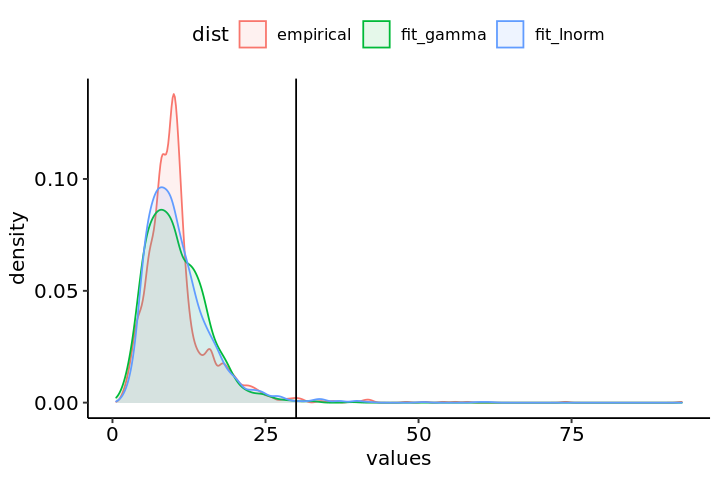

In [26]:
# using a parametric-based test
# to compute the probability of 
# occurrence of a value of length
# as extreme or more extreme than those
# observed in the SVAs of the genome
# I used log normal distribution
# and gamma distribution for parameter
# estimation and used the gamma distribution
# to compute a pvalue

# getting a vector with repeat size
# the n in (MOTIF)n
round_nrpt = round(sva_att_wide$rpt_n_rpt)
round_nrpt = round_nrpt[!is.na(round_nrpt)]

# first, I fitted my data to a gamma distribution
# getting the parameters of the gamma distribution
# using a maximum-likelihood estimator
mle_gamma = fitdistr(x = round_nrpt, densfun = "gamma")

# I created a sample from a gamma distribution
# with the parameters obtained from my data
my_fit_gamma = rgamma(n = length(round_nrpt), shape = mle_gamma$estimate[1], rate = mle_gamma$estimate[2])

# then, I did the same using the log normal distribution
mle_lnorm = fitdistr(x = round_nrpt, densfun = "log-normal")
my_fit_lnorm = rlnorm(n = length(round_nrpt), meanlog = mle_lnorm$estimate[1], sdlog = mle_lnorm$estimate[2])

# I checked those distributions using ggplot2
tib = tibble(empirical = round_nrpt,
             fit_lnorm = my_fit_lnorm,
             fit_gamma = my_fit_gamma) %>% 
    pivot_longer(cols = empirical:fit_gamma, names_to = "dist", values_to = "values")

options(repr.plot.width = 6, repr.plot.height = 4)
tib %>% 
    ggplot(aes(x = values, fill = dist, color = dist)) +
    geom_density(alpha = 0.1) +
    geom_vline(xintercept = 30)

# I will assume my data came from a population
# that can be modeled by a gamma distribution, and
# I will compute a p-value.
# this p-value will be the probability of observing
# a length as extreme or more extreme than that (therefore 30-1)
# we observed in XDP
# 35-52 in Bragg 2017
# 30-55 in Westenberger 2019
# 35-57 in Luth 2022
# min. length observed in these studies
p_value_gamma = pgamma(q = 30-1, rate = mle_gamma$estimate[1], shape = mle_gamma$estimate[2], lower.tail = F)

In [27]:
# computing the probability of
# observing a value as extreme or more extreme
# than the observation considering the empirical
# distribution
# we decided to use this in the paper:
# less assumptions required
observed_value = 30
p_obs = sum(round_nrpt >= observed_value)/length(round_nrpt)
p_obs

[1] 0.01398601

In [28]:
# # experimental feature
# # using simulation (bootstrap) to determine a pvalue
# # Compute the observed test statistic
# observed_value = 30
# observed_statistic = sum(round_nrpt >= observed_value)/length(round_nrpt)

# # Perform the bootstrap procedure
# n_bootstrap = 100000
# null_distribution = numeric(n_bootstrap)

# for (i in 1:n_bootstrap) {
#   resampled_data = sample(round_nrpt, size = length(round_nrpt), replace = T)
#   # null_distribution[i] = mean(resampled_data)
#   null_distribution[i] = sum(resampled_data >= observed_value)
# }

# # I observed those distributions using ggplot2
# tib = bind_rows(tibble(dist = "empirical", values = round_nrpt),
#                 tibble(dist = "bootstrapped_proportion", values = null_distribution))

# tib %>% 
#     ggplot(aes(x = values, color = dist)) +
#     geom_density() +
#     geom_vline(xintercept = 30) +
#     ylim(0,1)

# # Calculate the p-value
# p_value_boot = sum(observed_statistic >= null_distribution) / n_bootstrap
# p_value_boot

Warning message:
“Removed 438 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 438 rows containing missing values (position_quasirandom).”
Warning message:
“Removed 438 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 438 rows containing missing values (position_quasirandom).”


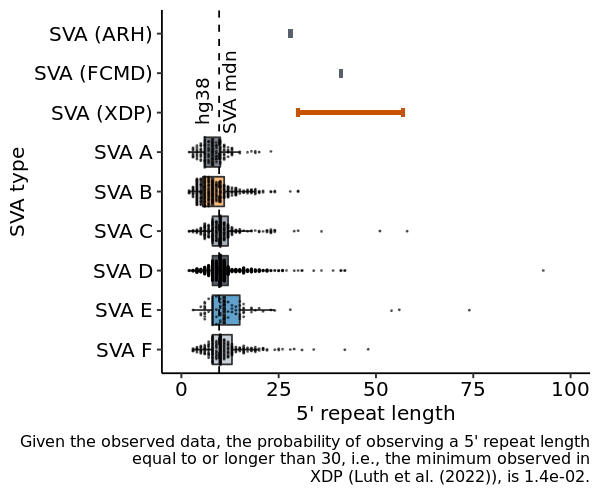

In [29]:
options(repr.plot.width = 5, repr.plot.height = 4.125)
rpt_length_median = sva_att_wide$rpt_n_rpt %>% median(na.rm = T)

sva_types = sva_att_wide$sva_type %>% unique() %>% sort()
sva_types_rev = sva_types %>% rev()

# 35-52 in Bragg 2017
# 30-55 in Westenberger 2019
# 35-57 in Luth 2022
sva_types_5prime_length_plot = sva_att_wide %>% 
    ggplot(aes(x = factor(x = sva_type,
                          levels = sva_types_rev,
                          labels = str_replace(sva_types_rev, "_", " ")),
               y = round(rpt_n_rpt),
               fill = sva_type)) +
    geom_boxplot(outlier.shape = NA,
                 show.legend = F) +
    geom_quasirandom(size = 0.2, alpha = 0.5,
                     show.legend = F) +
    geom_hline(yintercept = rpt_length_median, linetype = 2, size = 0.5, color = "black") +
    annotate(geom = "text", x = "SVA (XDP)", y = rpt_length_median + 3,
             label="hg38\nSVA mdn", angle = 90, color = "black", vjust = 0.125, hjust = 0.25) + 
    geom_errorbar(mapping=aes(x = "SVA (XDP)", ymin=30, ymax=57), width=0.2, size=1, color = "#c85200") +
    # annotate(geom = "text", x = "SVA XDP", y = (57*6)+10,
    #          label="XDP SVA F\n(Luth et al., 2022)", angle = 0,
    #          color = "#1170aa", vjust = 1, hjust = 0) + 
    geom_errorbar(mapping=aes(x = "SVA (FCMD)", ymin=41, ymax=41), width=0.2, size=1, color = "#57606c") +
    geom_errorbar(mapping=aes(x = "SVA (ARH)", ymin=28, ymax=28), width=0.2, size=1, color = "#57606c") +
    # annotate(geom = "text", x = "SVA FCMD", y = (41*6)+10,
    #          label="FCMD SVA\n(Taniguchi-Ikeda et al., 2012)", angle = 0,
    #          color = "#fc7d0b", vjust = 1, hjust = 0) +
    # geom_hline(yintercept = 21*6, linetype = 2, size = 0.5,
    #            color = "#4E79A7") +
    # annotate(geom = "text", x = "Ref.", y = (21*6)+15,
    #          label="Ref. gen. XDP SVA_F", angle = 0,
    #          color = "#4E79A7", vjust = -1, , hjust = 0) + 
    # geom_hline(yintercept = 35*6, linetype = 2, size = 0.5, color = "#1170aa") +
    # annotate(geom = "text", x = "XDP", y = (35*6)+15,
    #          label="Min. XDP SVA F\n(Luth et al., 2022)", angle = 0,
    #          color = "#1170aa", vjust = 1, hjust = 0) + 
    # geom_hline(yintercept = 57*6, linetype = 2, size = 0.5, color = "#fc7d0b") +
    # annotate(geom = "text", x = "XDP", y = (57*6)+15,
    #          label="Max. XDP SVA F\n(Luth et al., 2022)", angle = 0,
    #          color = "#fc7d0b", vjust = 3, hjust = 0) + 
    ylab("5' repeat length") +
    xlab("SVA type") +
    labs(caption = paste0("Given the observed data, the probability of observing a 5' repeat length\nequal to or longer than 30, i.e., the minimum observed in\nXDP (Luth et al. (2022)), is ", format(p_obs, scientific = T, digits = 3), ".")) +
    scale_y_continuous(breaks = seq(0, 100, 25), limits = c(0, 100)) +
    scale_x_discrete(limits=rev) +
    scale_fill_tableau(palette = "Color Blind") +
    coord_flip() #+
    #theme_pubr(x.text.angle = 45, base_family = "Arial")

ggsave(filename = "sva_types_5prime_length_plot.pdf",
       plot = sva_types_5prime_length_plot,
       width = 5,
       height = 4.125,
       units = "in",
       dpi = 600)

sva_types_5prime_length_plot

## 5' profile for SVAs having a 5' repeat (control samples only)

Based on the previous script, I will plot the same 5' profile charts using only control samples. This time, only SVAs harboring 5' repeats will be included.

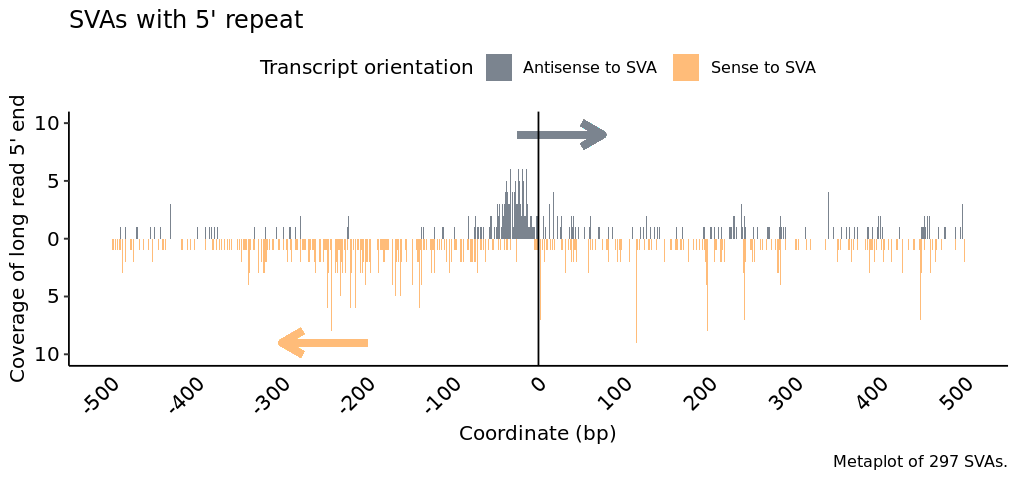

In [30]:
options(repr.plot.width = 8.49, repr.plot.height = 4)

# five_prime_cov
n = sva_fiverpt_tx_tib$sva_name %>% unique() %>% length()
plots_five_prime_cov_wrpt = sva_fiverpt_tx_tib %>%
    mutate(counts = counts * -1) %>%
    mutate(coordinate = coordinate * -1) %>%
    mutate() %>%
    ggplot(aes(x = coordinate,
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = T, width = 1) +
    geom_segment(aes(x = -25, xend = 75, y = 9, yend = 9),
                 arrow = arrow(length=unit(.5, 'cm')),
                 color = tableau10_col_blind_mod$value[1], size = 2) +
    geom_segment(aes(x = -200, xend = -300, y = -9, yend = -9),
                 arrow = arrow(length=unit(.5, 'cm')),
                 color = tableau10_col_blind_mod$value[2], size = 2) +
    geom_vline(xintercept = 0, size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    xlab("Coordinate (bp)") +
    labs(title = "SVAs with 5' repeat",
         caption = paste0("Metaplot of ", n, " SVAs.")) +
    scale_y_continuous(name = "Coverage of long read 5' end",
                       limits = c(-10, 10),
                       labels = abs) +
    scale_x_continuous(breaks = seq(-500, 500, 100)) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense to SVA",
                                  "sense" = "Sense to SVA")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_wrpt

## 5' profile for SVAs not having a 5' repeat (control samples only)

Based on the previous script, I will plot the same 5' profile charts using only control samples. This time, only SVAs harboring 5' repeats will be included.

Warning message:
“Removed 4 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_col).”


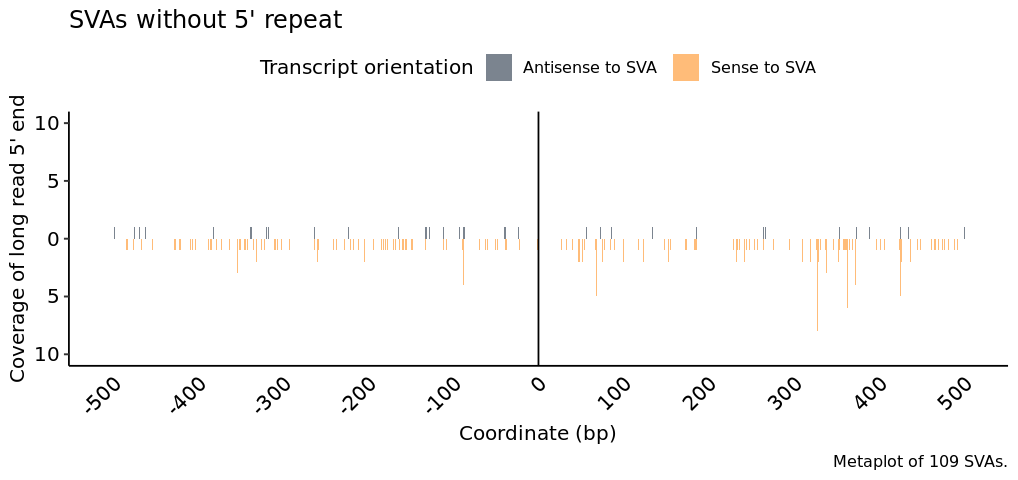

In [31]:
options(repr.plot.width = 8.49, repr.plot.height = 4)
# five_prime_cov
n = sva_norpt_tx_tib$sva_name %>% unique() %>% length()
plots_five_prime_cov_worpt = sva_norpt_tx_tib %>%
    mutate(counts = counts * -1) %>%
    mutate(coordinate = coordinate * -1) %>%
    ggplot(aes(x = coordinate,
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = T, width = 1) +
    geom_vline(xintercept = 0, size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    xlab("Coordinate (bp)") +
    labs(title = "SVAs without 5' repeat",
         caption = paste0("Metaplot of ", n, " SVAs.")) +
    scale_y_continuous(name = "Coverage of long read 5' end",
                       limits = c(-10, 10),
                       labels = abs) +
    scale_x_continuous(breaks = seq(-500, 500, 100)) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense to SVA",
                                  "sense" = "Sense to SVA")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_worpt

## 5' profile for SVAs (w/ and wo/ same panel) (control samples only)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


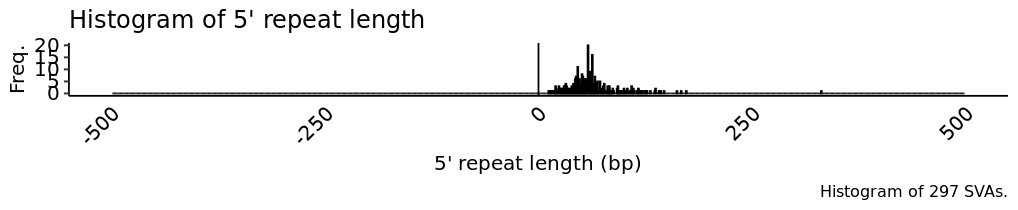

In [32]:
options(repr.plot.width = 8.49, repr.plot.height = 1.75)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_histlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% 
    ggplot(aes(x = rpt_length)) +
    geom_histogram(fill = "white", color = "black", bins = 1000) +
    scale_x_continuous(limits = c(-500, 500)) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("5' repeat length (bp)") +
    ylab("Freq.") +
    labs(title = "Histogram of 5' repeat length",
         caption = paste0("Histogram of ", n, " SVAs.")) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_histlen

Warning message:
“Ignoring unknown parameters: bins”


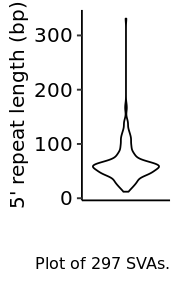

In [33]:
options(repr.plot.width = 1.5, repr.plot.height = 2.35)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_violinlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% 
    ggplot(aes(y = rpt_length, x = "")) +
    geom_violin(fill = "white", color = "black", bins = 1000) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("") +
    ylab("5' repeat length (bp)") +
    labs(
        # title = "Violin plot of 5' repeat length",
        caption = paste0("Plot of ", n, " SVAs.")
    ) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))

plots_five_prime_cov_violinlen

ggsave(filename = "sva_5prime_repeat_length_of_svas_w_coverage_violin.pdf",
       plot = plots_five_prime_cov_violinlen,
       width = 2,
       height = 2.35,
       units = "in",
       dpi = 600)

Warning message:
“Ignoring unknown parameters: bins”


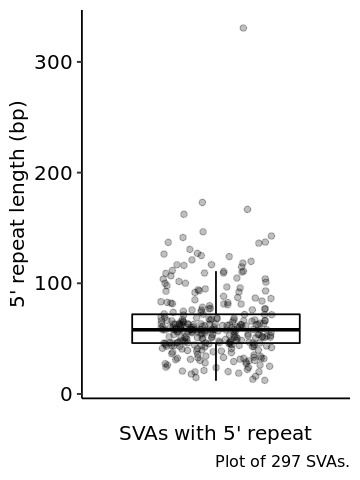

In [34]:
options(repr.plot.width = 3, repr.plot.height = 4)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_boxlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib$sva_name) %>% 
    ggplot(aes(y = rpt_length, x = "")) +
    geom_boxplot(fill = "white", color = "black", bins = 1000, outlier.shape = NA) +
    geom_jitter(width = 0.25, alpha = 0.25) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("SVAs with 5' repeat") +
    ylab("5' repeat length (bp)") +
    labs(
        # title = "Violin plot of 5' repeat length",
        caption = paste0("Plot of ", n, " SVAs.")
    ) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))

plots_five_prime_cov_boxlen

ggsave(filename = "sva_5prime_repeat_length_of_svas_w_coverage_boxplot.pdf",
       plot = plots_five_prime_cov_boxlen,
       width = 6,
       height = 8,
       units = "in",
       dpi = 600)

In [35]:
options(repr.plot.width = 8.49, repr.plot.height = 0.25)
sva_track = tibble(start = 0,
       end = 500) %>%
  ggplot() +
  geom_rect(aes(xmin = start, xmax = end, 
                ymin = 0, ymax = 1),
            fill = "#D55E00",
            color = "black") +
  geom_segment(aes(x = 485, xend = 490, y = 0.5, yend = 0.5),
                   arrow = arrow(length=unit(0.5, 'cm')),
                   color = "black", size = 2) +
  geom_segment(aes(x = 50, xend = 55, y = 0.5, yend = 0.5),
                   arrow = arrow(length=unit(0.5, 'cm')),
                   color = "black", size = 2) +
  geom_text(aes(x = (start + end) / 2, y = 0.5), label = "SVA") +
  scale_x_continuous(limits = c(-500, 500)) +
  theme_void()
  # theme(axis.text.y = element_blank(),
  #       axis.ticks.x = element_blank(),
  #       axis.text.x = element_text(hjust = 1,
  #                                  angle = 45))
sva_track

Warning message:
“Removed 4 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_col).”


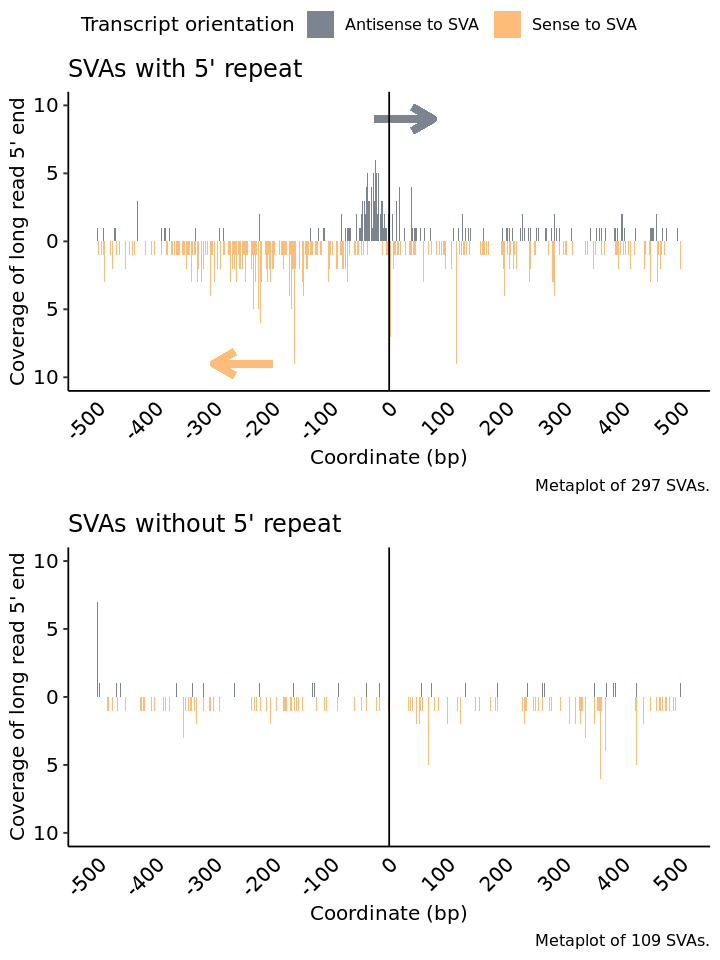

In [36]:
options(repr.plot.width = 6, repr.plot.height = 8)

sva_antisense_expression_panel = ggarrange(plotlist = list(plots_five_prime_cov_wrpt,
                                                           # sva_track,
                                                           # plots_five_prime_cov_histlen,
                                                           plots_five_prime_cov_worpt), 
                                           ncol = 1, nrow = 2,
                                           legend = "top",
                                           align = "v",
                                           common.legend = T,
                                           heights = c(0.4,
                                                       # 0.025,
                                                       # 0.2
                                                       0.4))

ggsave(filename = "sva_antisense_expression_panel.pdf",
       plot = sva_antisense_expression_panel,
       width = 6,
       height = 8,
       units = "in",
       dpi = 600)

sva_antisense_expression_panel

### Checking the expression of each SVA (control samples only)

Here we are going to create a heat map showing the number of reads starting at the five prime repeat of SVAs.

png 
  2

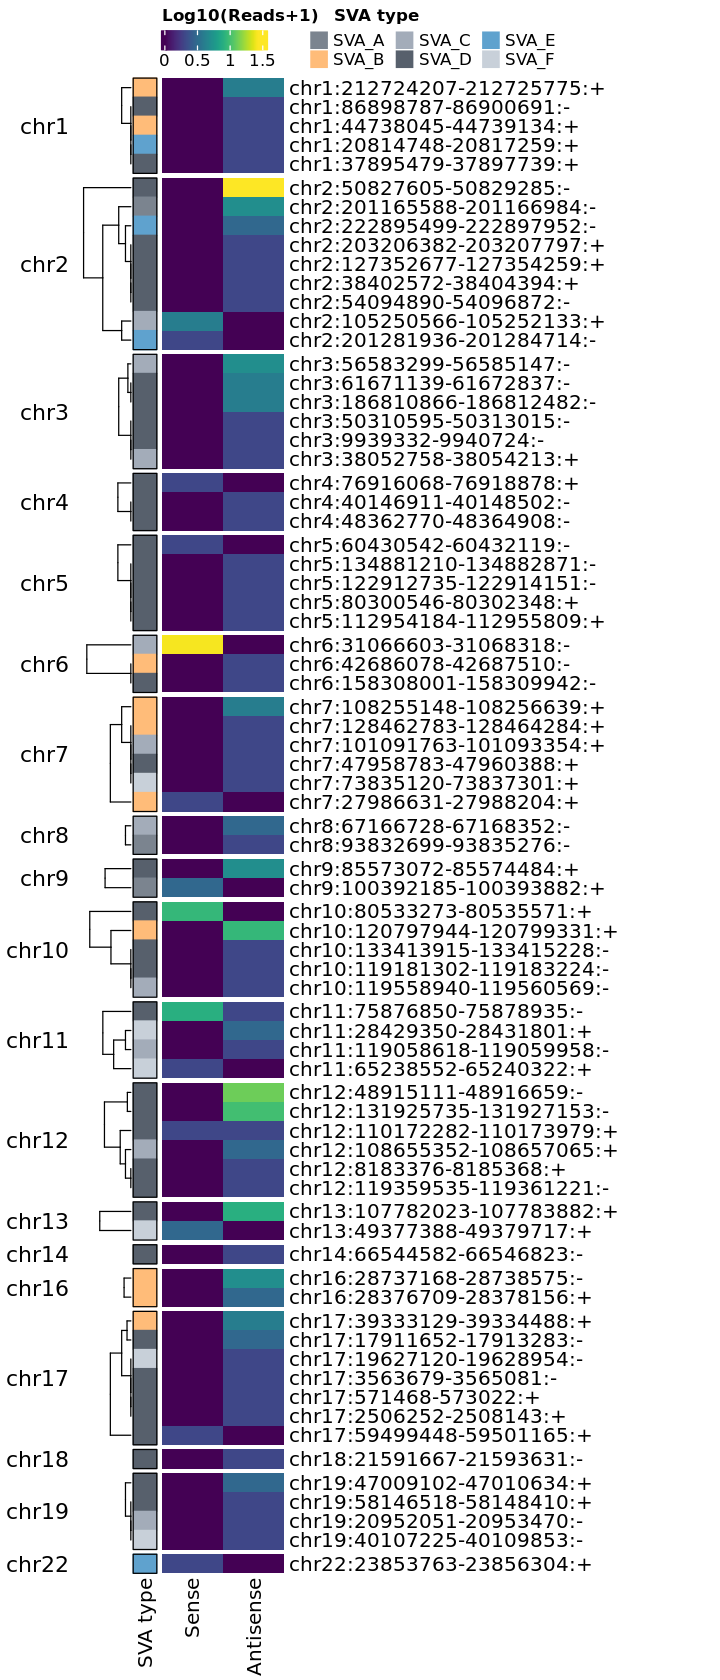

In [37]:
options(repr.plot.width = 6, repr.plot.height = 14)

# defining matrices
M_ori = sva_att_wide %>% 
    mutate(chr = str_replace(name, "^(chr.*?):.*$", "\\1")) %>% 
    dplyr::select(name, chr, sva_type, rpt_read_start_sense, rpt_read_start_antisense) %>% 
    filter(!is.na(rpt_read_start_sense) | !is.na(rpt_read_start_antisense)) %>% 
    mutate(across(.cols = c(rpt_read_start_sense, rpt_read_start_antisense),
                  .fns = ~ ifelse(is.na(.x), 0, .x)))

M = M_ori %>% dplyr::select(-c(name, chr, sva_type)) %>% as.matrix()
rownames(M) = M_ori$name

svaNames = paste0("SVA_", LETTERS[1:6])
svaCols = tableau10_col_blind_mod$value[1:6]
names(svaCols) = svaNames

heatCols = list(
  svaCol = svaCols
)

# defining legend object
heatLegs = list(
    sva_type = Legend(title = "    SVA type",
                      ncol = 3, by_row = F,
                      at = names(heatCols$svaCol),
                      legend_gp = gpar(fill = heatCols$svaCol %>% unname()))
)

# defining row annotation
row_ha = HeatmapAnnotation(which = "row",
                           sva_type = anno_simple(M_ori$sva_type,
                                                       border = T,
                                                       col = heatCols$svaCol),
                           # Chromosome = anno_simple(hmaFuncat$Chromosome,
                           #                           col = heatCols$chrCol,
                           #                           border = T),
                           annotation_label = c("SVA type")
                           )

# setting up order of row split
chrs = c(paste0("chr", 1:22), "chrX", "chrY", "chrM")
chrs = chrs[chrs %in% M_ori$chr]

# building heatmap
H = Heatmap(matrix = log10(M+1),
            cluster_columns = F,
            row_split = factor(M_ori$chr, levels = chrs),
            cluster_row_slices = F,
            row_title_rot = 0,
            column_labels = c("Sense", "Antisense"),
            left_annotation = row_ha,
            show_row_names = T,
            row_names_max_width = unit(12, "cm"),
            row_labels = str_replace(M_ori$name, ":SVA.*$", "") %>% 
                str_replace(., "(.*):(.*):(.*):(.*)", "\\1:\\2-\\3:\\4"),
            col = viridis::viridis(n = 100),
            show_heatmap_legend = T,
            heatmap_legend_param = list(
                 title = "Log10(Reads+1)",
                  direction = "horizontal"))

draw(H, padding = unit(c(2, 2, 2, 30), "mm"),
     annotation_legend_list = heatLegs,
     heatmap_legend_side = "top",
     annotation_legend_side = "top",
     merge_legend = TRUE)

# saving
pdf(file = "five_prime_repeat_read_abundance_heatmap.pdf",
    width = 6,
    height = 14)
draw(H, padding = unit(c(2, 2, 2, 30), "mm"),
     annotation_legend_list = heatLegs,
     heatmap_legend_side = "top",
     annotation_legend_side = "top",
     merge_legend = TRUE)
# draw(heatLegs$sva_type,
#      x = unit(0.8, "npc"),
#      y = unit(0.375, "npc"))
dev.off()
# graphics.off()

## 5' profile for SVAs having a 5' repeat (Alzheimer's samples only)

Based on the previous script, I will plot the same 5' profile charts using only Alzheimer's samples. This time, only SVAs harboring 5' repeats will be included.

In [ ]:
options(repr.plot.width = 8.49, repr.plot.height = 4)

# five_prime_cov
n = sva_fiverpt_tx_tib_alz$sva_name %>% unique() %>% length()
plots_five_prime_cov_wrpt = sva_fiverpt_tx_tib_alz %>%
    mutate(counts = counts * -1) %>%
    mutate(coordinate = coordinate * -1) %>%
    mutate() %>%
    ggplot(aes(x = coordinate,
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = T, width = 1) +
    geom_segment(aes(x = -25, xend = 75, y = 9, yend = 9),
                 arrow = arrow(length=unit(.5, 'cm')),
                 color = tableau10_col_blind_mod$value[1], size = 2) +
    geom_segment(aes(x = -200, xend = -300, y = -9, yend = -9),
                 arrow = arrow(length=unit(.5, 'cm')),
                 color = tableau10_col_blind_mod$value[2], size = 2) +
    geom_vline(xintercept = 0, size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    xlab("Coordinate (bp)") +
    labs(title = "SVAs with 5' repeat",
         caption = paste0("Metaplot of ", n, " SVAs.")) +
    scale_y_continuous(name = "Coverage of long read 5' end",
                       limits = c(-10, 10),
                       labels = abs) +
    scale_x_continuous(breaks = seq(-500, 500, 100)) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense to SVA",
                                  "sense" = "Sense to SVA")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_wrpt

## 5' profile for SVAs not having a 5' repeat (Alzheimer's samples only)

Based on the previous script, I will plot the same 5' profile charts using only Alzheimer's samples. This time, only SVAs harboring 5' repeats will be included.

In [ ]:
options(repr.plot.width = 8.49, repr.plot.height = 4)
# five_prime_cov
n = sva_norpt_tx_tib_alz$sva_name %>% unique() %>% length()
plots_five_prime_cov_worpt = sva_norpt_tx_tib_alz %>%
    mutate(counts = counts * -1) %>%
    mutate(coordinate = coordinate * -1) %>%
    ggplot(aes(x = coordinate,
               y = counts,
               fill = coverage_orientation)) +
    geom_col(show.legend = T, width = 1) +
    geom_vline(xintercept = 0, size = 0.5) +
    # geom_vline(xintercept = "72", linetype = 2, size = 0.5) +
    xlab("Coordinate (bp)") +
    labs(title = "SVAs without 5' repeat",
         caption = paste0("Metaplot of ", n, " SVAs.")) +
    scale_y_continuous(name = "Coverage of long read 5' end",
                       limits = c(-10, 10),
                       labels = abs) +
    scale_x_continuous(breaks = seq(-500, 500, 100)) +
    scale_fill_tableau(palette = "Color Blind",
                       name = "Transcript orientation",
                       labels = c("antisense" = "Antisense to SVA",
                                  "sense" = "Sense to SVA")) +
    theme_pubr() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_worpt

## 5' profile for SVAs (w/ and wo/ same panel) (Alzheimer's samples only)

In [ ]:
options(repr.plot.width = 8.49, repr.plot.height = 1.75)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_histlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% 
    ggplot(aes(x = rpt_length)) +
    geom_histogram(fill = "white", color = "black", bins = 1000) +
    scale_x_continuous(limits = c(-500, 500)) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("5' repeat length (bp)") +
    ylab("Freq.") +
    labs(title = "Histogram of 5' repeat length",
         caption = paste0("Histogram of ", n, " SVAs.")) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))
plots_five_prime_cov_histlen

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 4)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_violinlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% 
    ggplot(aes(y = rpt_length, x = "")) +
    geom_violin(fill = "white", color = "black", bins = 1000) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("SVAs with 5' repeat") +
    ylab("5' repeat length (bp)") +
    labs(
        # title = "Violin plot of 5' repeat length",
        caption = paste0("Plot of ", n, " SVAs.")
    ) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))

plots_five_prime_cov_violinlen

ggsave(filename = "sva_5prime_repeat_length_of_svas_w_coverage_violin_alz.pdf",
       plot = plots_five_prime_cov_violinlen,
       width = 3,
       height = 4,
       units = "in",
       dpi = 600)

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 4)
n = sva_att_wide %>% filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% pull(name) %>%  unique() %>% length()
plots_five_prime_cov_boxlen = sva_att_wide %>% 
    filter(name %in% sva_fiverpt_tx_tib_alz$sva_name) %>% 
    ggplot(aes(y = rpt_length, x = "")) +
    geom_boxplot(fill = "white", color = "black", bins = 1000, outlier.shape = NA) +
    geom_jitter(width = 0.25, alpha = 0.25) +
    geom_vline(xintercept = 0, size = 0.5) +
    xlab("SVAs with 5' repeat") +
    ylab("5' repeat length (bp)") +
    labs(
        # title = "Violin plot of 5' repeat length",
        caption = paste0("Plot of ", n, " SVAs.")
    ) +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_text(hjust = 1,
                                     angle = 45))

plots_five_prime_cov_boxlen

ggsave(filename = "sva_5prime_repeat_length_of_svas_w_coverage_boxplot_alz.pdf",
       plot = plots_five_prime_cov_boxlen,
       width = 6,
       height = 8,
       units = "in",
       dpi = 600)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 8)

sva_antisense_expression_panel = ggarrange(plotlist = list(plots_five_prime_cov_wrpt,
                                                           # sva_track,
                                                           # plots_five_prime_cov_histlen,
                                                           plots_five_prime_cov_worpt), 
                                           ncol = 1, nrow = 2,
                                           legend = "top",
                                           align = "v",
                                           common.legend = T,
                                           heights = c(0.4,
                                                       # 0.025,
                                                       # 0.2
                                                       0.4))

ggsave(filename = "sva_antisense_expression_panel_alz.pdf",
       plot = sva_antisense_expression_panel,
       width = 6,
       height = 8,
       units = "in",
       dpi = 600)

sva_antisense_expression_panel

## Association of SVA features

### Checking the expression of groups of SVAs

#### Frequency of SVA having at least one long read transcribed from the five prime repeat sense and antisense

In [ ]:
options(repr.plot.width = 6.25, repr.plot.height = 5)
fac_order = c("Antisense", "Sense", "Both", "None")

absolute_freq_svas_with_five_prime_rpt = sva_att_wide %>% 
    mutate(tx_status = case_when(!is.na(rpt_read_start_sense) & !is.na(rpt_read_start_antisense) ~ "Both",
                                 !is.na(rpt_read_start_sense) ~ "Sense",
                                 !is.na(rpt_read_start_antisense) ~ "Antisense",
                                 is.na(rpt_read_start_sense) & is.na(rpt_read_start_antisense) ~ "None")) %>% 
    group_by(sva_type, tx_status) %>%
    summarise(count = n(), .groups = "drop") %>%
    complete(sva_type, tx_status, fill = list(count = NA_integer_)) %>% 
    mutate(tx_status = factor(tx_status, levels = fac_order)) %>% 
    ggplot(aes(y = log10(count), x = sva_type, fill = tx_status)) +
    geom_col(position = "dodge") +
    scale_fill_tableau(name = "Orientation of long reads\nstarting at the 5' repeat",
                       palette = "Color Blind") +
    ylab("Log10(Frequency)") +
    xlab("SVA type")
absolute_freq_svas_with_five_prime_rpt

#### Relative frequency of SVA having at least one long read transcribed from the five prime repeat sense and antisense

In [ ]:
options(repr.plot.width = 6.25, repr.plot.height = 5)
fac_order = c("Antisense", "Sense", "Both", "None")

relative_freq_svas_with_five_prime_rpt = sva_att_wide %>%
  mutate(tx_status = case_when(!is.na(rpt_read_start_sense) & !is.na(rpt_read_start_antisense) ~ "Both",
                               !is.na(rpt_read_start_sense) ~ "Sense",
                               !is.na(rpt_read_start_antisense) ~ "Antisense",
                               is.na(rpt_read_start_sense) & is.na(rpt_read_start_antisense) ~ "None")) %>%  
  group_by(sva_type, tx_status) %>%
  summarise(count = n(), .groups = "drop") %>%
  complete(sva_type, tx_status, fill = list(count = 0)) %>% 
  mutate(total = tapply(count, sva_type, sum)[sva_type]) %>%
  mutate(percentage = count/total) %>%
  mutate(tx_status = factor(tx_status, levels = fac_order)) %>% 
  ggplot(aes(x = sva_type, y = percentage, fill = tx_status)) +
  geom_bar(position = "dodge", stat = "identity") +
  scale_fill_tableau(name = "Orientation of long reads\nstarting at the 5' repeat",
                     palette = "Color Blind") +
  ylab("Relative frequency") +
  xlab("SVA type")
relative_freq_svas_with_five_prime_rpt

In [ ]:
# combining both above into a single plot
options(repr.plot.width = 6, repr.plot.height = 5)

ggarrange(plotlist = list(absolute_freq_svas_with_five_prime_rpt,
                          relative_freq_svas_with_five_prime_rpt), 
          ncol = 1, nrow = 2,
          legend = "top",
          align = "v",
          common.legend = T)

#### Frequency of SVA reads being transcribed from the five prime repeat sense and antisense

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
fac_order = c("rpt_read_start_antisense", "rpt_read_start_sense")

sva_att_wide %>% 
    filter(has_rpt == "yes") %>% 
    group_by(sva_type) %>% 
    summarise(rpt_read_start_sense = sum(rpt_read_start_sense, na.rm = T),
              rpt_read_start_antisense = sum(rpt_read_start_antisense, na.rm = T),
              sva_type_n = n()) %>% 
    pivot_longer(cols = c("rpt_read_start_sense", "rpt_read_start_antisense"),
                 names_to = "orientation",
                 values_to = "reads") %>% 
    mutate(orientation = factor(orientation, levels = fac_order)) %>% 
    ggplot(aes(y = reads, x = sva_type, fill = orientation)) +
    geom_col(position = "dodge") +
    scale_fill_tableau(name = "Orientation of long reads\nstarting at the 5' repeat",
                       palette = "Color Blind", 
                       labels = c("rpt_read_start_sense" = "Sense",
                                  "rpt_read_start_antisense" = "Antisense")) +
    ylab("Number of long reads starting at the 5'repeat") +
    xlab("SVA type")

#### Relative frequency of SVA reads being transcribed from the five prime repeat sense and antisense

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
fac_order = c("rpt_read_start_antisense", "rpt_read_start_sense")

sva_att_wide %>% 
    filter(has_rpt == "yes") %>% 
    group_by(sva_type) %>% 
    summarise(rpt_read_start_sense = sum(rpt_read_start_sense, na.rm = T),
              rpt_read_start_antisense = sum(rpt_read_start_antisense, na.rm = T)) %>% 
    pivot_longer(cols = c("rpt_read_start_sense", "rpt_read_start_antisense"),
                 names_to = "orientation",
                 values_to = "reads") %>%
    ungroup() %>% 
    group_by(sva_type) %>% 
    mutate(reads_pct = reads / sum(reads) * 100) %>% 
    mutate(orientation = factor(orientation, levels = fac_order)) %>% 
    ggplot(aes(y = reads_pct, x = sva_type,
               fill = orientation, label = reads)) +
    geom_col(position = "fill") +
    geom_label(show.legend = F, position = "fill") +
    scale_fill_tableau(name = "Orientation of long reads\nstarting at the 5' repeat",
                       palette = "Color Blind", 
                       labels = c("rpt_read_start_sense" = "Sense",
                                  "rpt_read_start_antisense" = "Antisense")) +
    ylab("Relative frequency") +
    xlab("SVA type")
    

### Checking presence of 5' repeat in terms of SVA type

In [49]:
### Checking presence of 5' repeat in terms of SVA type
svaType_vs_svaPres_p = enrichAnalysis(df = sva_att_wide,
                                      subvec = sva_att_wide %>% filter(sva_type == "SVA_F") %>% pull(name),
                                      testcol = "has_rpt",
                                      lev = "no",
                                      mode = "enrichment")

svaType_vs_svaPres_p

svaType_vs_svaPres_p = svaType_vs_svaPres_p$pval %>%
    format(scientific = T, digits = 2)

,has_rpt:no,has_rpt:background,total
target_subvec,137,195,332
background_subvec,301,1521,1822
total,438,1716,2154


`summarise()` has grouped output by 'sva_type'. You can override using the
`.groups` argument.


png 
  2

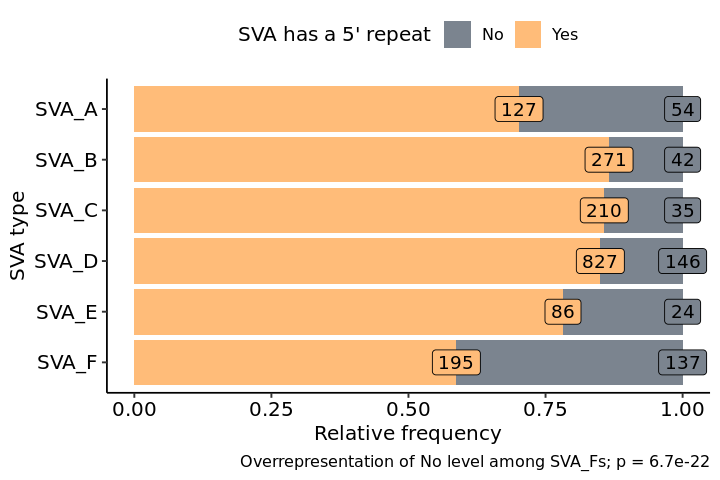

In [50]:
options(repr.plot.height = 4, repr.plot.width = 6)
sva_type__vs__presence_of_5rpt = sva_att_wide %>% 
  group_by(sva_type, has_rpt) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = sva_type,
             fill = has_rpt,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA type") +
  labs(caption = paste0("Overrepresentation of No level among SVA_Fs; p = ", svaType_vs_svaPres_p)) +
  scale_y_discrete(limits = rev) +
  scale_fill_tableau(palette = "Color Blind",name = "SVA has a 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))
sva_type__vs__presence_of_5rpt

pdf(file = "sva_type__vs__presence_of_5rpt.pdf", height = 4, width = 6)
  sva_type__vs__presence_of_5rpt
dev.off()

### Checking the length of 5' repeats in the genomic context (alternative version)

In [51]:
### Checking the length of 5' repeats in the genomic context (alternative version)
rptLen_vs_genoCtxt = sva_att_wide %>% 
  filter(rpt_length >= 120 | is.na(rpt_length)) %>%
  mutate(rpt_length_cat = case_when(rpt_length >= 120 ~ ">= 120 bp",
                                   TRUE ~ "No repeat"))

rptLen_vs_genoCtxt_p = enrichAnalysis(df = rptLen_vs_genoCtxt,
               subvec = rptLen_vs_genoCtxt %>% filter(rpt_length_cat == ">= 120 bp") %>% pull(name),
               testcol = "relative_to_gene",
               lev = "intergenic",
               mode = "enrichment")

rptLen_vs_genoCtxt_p

rptLen_vs_genoCtxt_p = rptLen_vs_genoCtxt_p$pval %>%
    format(scientific = T, digits = 2)

,relative_to_gene:intergenic,relative_to_gene:background,total
target_subvec,48,49,97
background_subvec,167,271,438
total,215,320,535


`summarise()` has grouped output by 'rpt_length_cat'. You can override using
the `.groups` argument.


png 
  2

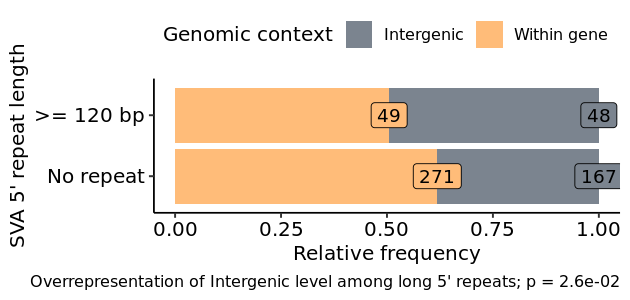

In [52]:
options(repr.plot.height = 2.5, repr.plot.width = 5.25)
genomic_context__vs__5rpt_length = rptLen_vs_genoCtxt %>% 
  group_by(rpt_length_cat, relative_to_gene) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("No repeat", ">= 120 bp")),
             fill = relative_to_gene,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Overrepresentation of Intergenic level among long 5' repeats; p = ", rptLen_vs_genoCtxt_p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Genomic context",
                     labels = c("within_gene" = "Within gene",
                                "intergenic" = "Intergenic"))
genomic_context__vs__5rpt_length

pdf(file = "genomic_context__vs__5rpt_length.pdf", height = 2.5, width = 5.25)
  genomic_context__vs__5rpt_length
dev.off()

### Checking genomic context in terms of transcription (deprecated)

In [53]:
### Checking genomic context in terms of transcription
# genoCtxt_vs_tx_p = enrichAnalysis(df = sva_att_wide,
#                subvec = sva_att_wide %>% filter(relative_to_gene == "within_gene") %>% pull(name),
#                testcol = "ovlp_transcript",
#                lev = "yes",
#                mode = "enrichment")

# genoCtxt_vs_tx_p

# genoCtxt_vs_tx_p = genoCtxt_vs_tx_p$pval %>%
#     format(scientific = T, digits = 2)

In [54]:
# options(repr.plot.height = 2.5, repr.plot.width = 5.25)
# sva_att_wide %>% 
#   group_by(relative_to_gene, ovlp_transcript) %>% 
#   summarise(count = n()) %>% 
#   ggplot(aes(x = count,
#              y = relative_to_gene,
#              fill = ovlp_transcript,
#              label = count)) +
#   geom_col(position = "fill") +
#   geom_label(position = "fill", show.legend = F) +
#   # geom_label_repel(aes(label = count),
#   #                  position = "fill",
#   #                  show.legend = F,
#   #                  size = 4,
#   #                  label.padding = 0.125,
#   #                  label.r = 0.18,
#   #                  min.segment.length = 0,
#   #                  segment.colour = "black",
#   #                  color = "black") + 
#   xlab("Relative frequency") +
#   ylab("Genomic context") +
#   labs(caption = paste0("Overrepresentation of Yes level among SVAs Within genes; p = ", genoCtxt_vs_tx_p)) +
#   scale_fill_tableau(palette = "Color Blind",name = "Proximal long read 5' prime end",,
#                      labels = c("yes" = "Yes",
#                                 "no" = "No")) +
#   scale_y_discrete(name = "Genomic context",
#                    labels = c("within_gene" = "Within gene",
#                               "intergenic" = "Intergenic"))

### Checking the length of 5' repeats in terms of transcription (deprecated)

In [55]:
# ### Checking the length of 5' repeats in terms of transcription
# rptLen_vs_tx = sva_att_wide %>% 
#   filter(rpt_length >= 120 | is.na(rpt_length)) %>%
#   mutate(rpt_length_cat = case_when(rpt_length >= 120 ~ ">= 120 bp",
#                                    TRUE ~ "No repeat"))

# rptLen_vs_tx_p = enrichAnalysis(df = rptLen_vs_genoCtxt,
#                subvec = rptLen_vs_genoCtxt %>% filter(rpt_length_cat == ">= 120 bp") %>% pull(name),
#                testcol = "ovlp_transcript",
#                lev = "no",
#                mode = "enrichment")

# rptLen_vs_tx_p

# rptLen_vs_tx_p = rptLen_vs_tx_p$pval %>%
#     format(scientific = T, digits = 2)

In [56]:
# options(repr.plot.height = 2.5, repr.plot.width = 5.25)
# rptLen_vs_tx %>% 
#   group_by(rpt_length_cat, ovlp_transcript) %>% 
#   summarise(count = n()) %>% 
#   ggplot(aes(x = count,
#              y = factor(rpt_length_cat, levels = c("No repeat",
#                                                     ">= 120 bp")),
#              fill = ovlp_transcript,
#              label = count)) +
#   geom_col(position = "fill") +
#   geom_label(position = "fill", show.legend = F) +
#   # geom_label_repel(aes(label = count),
#   #                  position = "fill",
#   #                  show.legend = F,
#   #                  size = 4,
#   #                  label.padding = 0.125,
#   #                  label.r = 0.18,
#   #                  min.segment.length = 0,
#   #                  segment.colour = "black",
#   #                  color = "black") + 
#   xlab("Relative frequency") +
#   ylab("SVA 5' repeat length") +
#   labs(caption = paste0("Overrepresentation of No level among long 5' repeats; p = ", rptLen_vs_tx_p)) +
#   scale_fill_tableau(palette = "Color Blind",name = "Proximal long read 5' prime end",
#                      labels = c("yes" = "Yes",
#                                 "no" = "No"))

### Checking the length of 5' repeats within genes (sense or antisense)

In [ ]:
### Checking the length of 5' repeats within genes (sense or antisense)
options(repr.plot.height = 3, repr.plot.width = 6)
sva_att_wide %>% 
  filter(!is.na(within_gene_simple)) %>% 
  group_by(rpt_length_cat, within_gene_simple) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("no hex",
                                                    "< 30 bp",
                                                    "30:59 bp",
                                                    "60:89 bp",
                                                    "90:119 bp",
                                                    "120:149 bp",
                                                    ">= 150 bp")),
             fill = within_gene_simple,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  scale_fill_tableau(palette = "Color Blind",name = "Within gene context",,
                     labels = c("sense" = "Sense",
                                "antisense" = "Antisense",
                                "sense_and_antisense" = "Sense and Antisense"))

### Checking the length of 5' repeats within genes (exon or intron)

In [ ]:
### Checking the length of 5' repeats within genes (exon or intron)
options(repr.plot.height = 3, repr.plot.width = 6)
sva_att_wide %>% 
  filter(!is.na(within_gene_complex)) %>% 
  group_by(rpt_length_cat, within_gene_complex) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("no hex",
                                                    "< 30 bp",
                                                    "30:59 bp",
                                                    "60:89 bp",
                                                    "90:119 bp",
                                                    "120:149 bp",
                                                    ">= 150 bp")),
             fill = within_gene_complex,
             label = count)) +
  geom_col(position = "fill") +
  geom_label_repel(aes(label = count),
                   position = "fill",
                   show.legend = F,
                   size = 4,
                   label.padding = 0.125,
                   label.r = 0.18,
                   min.segment.length = 0,
                   segment.colour = "black",
                   color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  scale_fill_tableau(palette = "Color Blind",name = "Within gene context",,
                     labels = c("exon" = "Exon",
                                "intron" = "Intron",
                                "utr" = "UTR"))

### Checking within gene context (sense and antisense) in terms of transcription (deprecated)

In [59]:
# ### Checking within gene context (sense and antisense) in terms of transcription
# options(repr.plot.height = 3, repr.plot.width = 6)
# sva_att_wide %>% 
#   filter(!is.na(within_gene_simple)) %>% 
#   group_by(within_gene_simple, ovlp_transcript) %>% 
#   summarise(count = n()) %>% 
#   ggplot(aes(x = count,
#              y = within_gene_simple,
#              fill = ovlp_transcript,
#              label = count)) +
#   geom_col(position = "fill") +
#   geom_label(position = "fill", show.legend = F) + 
#   # geom_label_repel(aes(label = count),
#   #                  position = "fill",
#   #                  show.legend = F,
#   #                  size = 4,
#   #                  label.padding = 0.125,
#   #                  label.r = 0.18,
#   #                  min.segment.length = 0,
#   #                  segment.colour = "black",
#   #                  color = "black") + 
#   xlab("Relative frequency") +
#   ylab("Genomic context") +
#   scale_fill_tableau(palette = "Color Blind",name = "Proximal long read 5' prime end",,
#                      labels = c("yes" = "Yes",
#                                 "no" = "No")) +
#   scale_y_discrete(name = "Gene context",
#                    labels = c("sense" = "Sense",
#                               "antisense" = "Antisense",
#                               "sense_and_antisense" = "Sense and Antisense"))

### Checking within gene context (exon and intron) in terms of transcription (deprecated)

In [60]:
# ### Checking within gene context (exon and intron) in terms of transcription
# options(repr.plot.height = 3, repr.plot.width = 6)
# sva_att_wide %>% 
#   filter(!is.na(within_gene_complex)) %>% 
#   group_by(within_gene_complex, ovlp_transcript) %>% 
#   summarise(count = n()) %>% 
#   ggplot(aes(x = count,
#              y = within_gene_complex,
#              fill = ovlp_transcript,
#              label = count)) +
#   geom_col(position = "fill") +
#   geom_label(position = "fill", show.legend = F) + 
#   # geom_label_repel(aes(label = count),
#   #                  position = "fill",
#   #                  show.legend = F,
#   #                  size = 4,
#   #                  label.padding = 0.125,
#   #                  label.r = 0.18,
#   #                  min.segment.length = 0,
#   #                  segment.colour = "black",
#   #                  color = "black") + 
#   xlab("Relative frequency") +
#   ylab("Genomic context") +
#   scale_fill_tableau(palette = "Color Blind",name = "Proximal long read 5' prime end",,
#                      labels = c("yes" = "Yes",
#                                 "no" = "No")) +
#   scale_y_discrete(name = "Gene context",
#                    labels = c("intron" = "Intron",
#                               "exon" = "Exon",
#                               "utr" = "UTR"))

### Checking SVA type in terms of transcription (deprecated)

In [61]:
# ### Checking SVA type in terms of transcription
# options(repr.plot.height = 3, repr.plot.width = 6)
# sva_att_wide %>% 
#   group_by(sva_type, ovlp_transcript) %>% 
#   summarise(count = n()) %>% 
#   ggplot(aes(x = count,
#              y = sva_type,
#              fill = ovlp_transcript,
#              label = count)) +
#   geom_col(position = "fill") +
#   geom_label(position = "fill", show.legend = F) + 
#   # geom_label_repel(aes(label = count),
#   #                  position = "fill",
#   #                  show.legend = F,
#   #                  size = 4,
#   #                  label.padding = 0.125,
#   #                  label.r = 0.18,
#   #                  min.segment.length = 0,
#   #                  segment.colour = "black",
#   #                  color = "black") + 
#   xlab("Relative frequency") +
#   ylab("SVA type") +
#   scale_y_discrete(limits = rev) +
#   scale_fill_tableau(palette = "Color Blind",name = "Proximal long read 5' prime end",,
#                      labels = c("yes" = "Yes",
#                                 "no" = "No"))

### Checking the length of 5' repeats in terms of reads starting (sense) at the 5' repeat (quantitative)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)
sva_att_wide %>% 
    filter(!is.na(rpt_length)) %>% 
    filter(!is.na(rpt_read_start_sense)) %>% 
    ggplot(aes(x = rpt_length,
               y = rpt_read_start_sense,
               color = sva_type)) + 
    geom_point() +
    # geom_smooth(inherit.aes = F,
    #         aes(x = rpt_length,
    #             y = rpt_read_start_sense),
    #         method = "loess") +
    facet_wrap(~ sva_type, scale = "free") +
    scale_color_tableau(palette = "Color Blind")
sva_att_wide %>% 
    filter(!is.na(rpt_length)) %>% 
    filter(!is.na(rpt_read_start_sense)) %>% 
    ggplot(aes(x = rpt_length,
               y = rpt_read_start_sense,
               color = sva_type)) + 
    geom_point() +
    # geom_smooth(inherit.aes = F,
    #         aes(x = rpt_length,
    #             y = rpt_read_start_sense),
    #         method = "loess") +
    # facet_wrap(~ sva_type, scale = "free") +
    scale_color_tableau(palette = "Color Blind")

### Checking the length of 5' repeats in terms of reads starting (antisense) at the 5' repeat (quantitative)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)
sva_att_wide %>% 
    filter(!is.na(rpt_length)) %>%
    filter(!is.na(rpt_read_start_antisense)) %>% 
    ggplot(aes(x = rpt_length,
               y = rpt_read_start_antisense,
               color = sva_type)) + 
    geom_point() +
    # geom_smooth(inherit.aes = F,
    #             aes(x = rpt_length,
    #                 y = rpt_read_start_antisense),
    #             method = "loess") +
    facet_wrap(~ sva_type, scale = "free") +
    scale_color_tableau(palette = "Color Blind")

sva_att_wide %>% 
    filter(!is.na(rpt_length)) %>%
    filter(!is.na(rpt_read_start_antisense)) %>% 
    ggplot(aes(x = rpt_length,
               y = rpt_read_start_antisense,
               color = sva_type)) + 
    geom_point() +
    # geom_smooth(inherit.aes = F,
    #             aes(x = rpt_length,
    #                 y = rpt_read_start_antisense),
    #             method = "loess") +
    # facet_wrap(~ sva_type, scale = "free") +
    scale_color_tableau(palette = "Color Blind")

### Checking the length of 5' repeats in terms of reads starting (sense) at the 5' repeat (qualitative)

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6.25)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_length_cat, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("no hex",
                                                    "< 30 bp",
                                                    "30:59 bp",
                                                    "60:89 bp",
                                                    "90:119 bp",
                                                    "120:149 bp",
                                                    ">= 150 bp")),
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))

In [65]:
### trying different cats
rptLen_vs_tx = sva_att_wide %>% 
  filter(rpt_length >= 120 | rpt_length < 60) %>%
  mutate(rpt_length_cat = case_when(rpt_length >= 120 ~ ">= 120 bp",
                                     TRUE ~ "< 60 bp"))

rptLen_vs_tx_p = enrichAnalysis(df = rptLen_vs_tx,
               subvec = rptLen_vs_tx %>% filter(rpt_length_cat == ">= 120 bp") %>% pull(name),
               testcol = "rpt_read_start_qual_sense",
               lev = "yes",
               mode = "enrichment")

rptLen_vs_tx_p

rptLen_vs_tx_p = rptLen_vs_tx_p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_sense:yes,rpt_read_start_qual_sense:background,total
target_subvec,3,94,97
background_subvec,5,953,958
total,8,1047,1055


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 6.25)
rptLen_vs_tx %>% 
  group_by(rpt_length_cat, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("< 60 bp", ">= 120 bp")),
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Overrepresentation of Yes level among long 5' repeats; p = ", rptLen_vs_tx_p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))

### Checking the length of 5' repeats in terms of reads starting (antisense) at the 5' repeat (qualitative)

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6.25)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_length_cat, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("no hex",
                                                    "< 30 bp",
                                                    "30:59 bp",
                                                    "60:89 bp",
                                                    "90:119 bp",
                                                    "120:149 bp",
                                                    ">= 150 bp")),
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))

In [68]:
### trying different cats
rptLen_vs_tx = sva_att_wide %>% 
  filter(rpt_length >= 120 | rpt_length < 60) %>%
  mutate(rpt_length_cat = case_when(rpt_length >= 120 ~ ">= 120 bp",
                                     TRUE ~ "< 60 bp"))

rptLen_vs_tx_p = enrichAnalysis(df = rptLen_vs_tx,
               subvec = rptLen_vs_tx %>% filter(rpt_length_cat == ">= 120 bp") %>% pull(name),
               testcol = "rpt_read_start_qual_antisense",
               lev = "yes",
               mode = "enrichment")

rptLen_vs_tx_p

rptLen_vs_tx_p = rptLen_vs_tx_p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_antisense:yes,rpt_read_start_qual_antisense:background,total
target_subvec,6,91,97
background_subvec,34,924,958
total,40,1015,1055


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 6.25)
rptLen_vs_tx %>% 
  group_by(rpt_length_cat, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("< 60 bp", ">= 120 bp")),
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))

In [70]:
### trying different cats
rptLen_vs_tx = sva_att_wide %>% 
  filter(rpt_length >= 120 | rpt_length < 30) %>%
  mutate(rpt_length_cat = case_when(rpt_length >= 120 ~ ">= 120 bp",
                                     TRUE ~ "< 30 bp"))

rptLen_vs_tx_p = enrichAnalysis(df = rptLen_vs_tx,
               subvec = rptLen_vs_tx %>% filter(rpt_length_cat == ">= 120 bp") %>% pull(name),
               testcol = "rpt_read_start_qual_antisense",
               lev = "yes",
               mode = "enrichment")

rptLen_vs_tx_p

rptLen_vs_tx_p = rptLen_vs_tx_p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_antisense:yes,rpt_read_start_qual_antisense:background,total
target_subvec,6,91,97
background_subvec,1,124,125
total,7,215,222


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 6.25)
rptLen_vs_tx %>% 
  group_by(rpt_length_cat, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = factor(rpt_length_cat, levels = c("< 30 bp", ">= 120 bp")),
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Overrepresentation of Yes level among long 5' repeats; p = ", rptLen_vs_tx_p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No"))

### Checking the genomic context in terms of reads starting (sense) at the 5' repeat (qualitative)

In [72]:
### Checking the genomic context in terms of reads starting (sense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% 
                                         filter(relative_to_gene == "within_gene") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_sense",
               lev = "yes",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_sense:yes,rpt_read_start_qual_sense:background,total
target_subvec,10,1000,1010
background_subvec,4,702,706
total,14,1702,1716


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 6.25)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(relative_to_gene, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = relative_to_gene,
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Overrepresentation of Yes level among SVAs Within gene; p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(name = "Genomic context",
                   labels = c("within_gene" = "Within gene",
                              "intergenic" = "Intergenic"))

### Checking the genomic context in terms of reads starting (antisense) at the 5' repeat (qualitative)

In [74]:
### Checking the genomic context in terms of reads starting (antisense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% 
                                         filter(relative_to_gene == "within_gene") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_antisense",
               lev = "yes",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_antisense:yes,rpt_read_start_qual_antisense:background,total
target_subvec,49,961,1010
background_subvec,13,693,706
total,62,1654,1716


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 6.25)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(relative_to_gene, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = relative_to_gene,
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Overrepresentation of Yes level among SVAs Within gene; p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(name = "Genomic context",
                   labels = c("within_gene" = "Within gene",
                              "intergenic" = "Intergenic"))

### Checking the "within gene" context in terms of reads starting (sense) at the 5' repeat (qualitative)

In [76]:
### Checking the "within gene" context in terms of reads starting (sense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic") %>% 
                                         filter(within_gene_simple == "sense") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_sense",
               lev = "yes",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_sense:yes,rpt_read_start_qual_sense:background,total
target_subvec,3,209,212
background_subvec,7,791,798
total,10,1000,1010


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 7)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  filter(relative_to_gene != "intergenic") %>% 
  group_by(within_gene_simple, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = within_gene_simple,
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  # labs(caption = paste0("Overrepresentation of Yes level among SVAs Within gene; p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(name = "Within gene context",
                   labels = c("sense" = "Sense",
                              "antisense" = "Antisense",
                              "sense_and_antisense" = "Sense/Antisense"))

### Checking the "within gene" context in terms of reads starting (antisense) at the 5' repeat (qualitative)

In [78]:
### Checking the "within gene" context in terms of reads starting (antisense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic") %>% 
                                         filter(within_gene_simple == "antisense") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_antisense",
               lev = "no",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_antisense:no,rpt_read_start_qual_antisense:background,total
target_subvec,700,30,730
background_subvec,261,19,280
total,961,49,1010


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 7)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  filter(relative_to_gene != "intergenic") %>% 
  group_by(within_gene_simple, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = within_gene_simple,
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  labs(caption = paste0("Enrichment of No level among SVAs Antisense to genes; p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(name = "Within gene context",
                   labels = c("sense" = "Sense",
                              "antisense" = "Antisense",
                              "sense_and_antisense" = "Sense/Antisense"))

In [80]:
### Checking the "within gene" context in terms of reads starting (antisense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic") %>% filter(within_gene_simple != "sense_and_antisense"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% filter(relative_to_gene != "intergenic") %>% filter(within_gene_simple != "sense_and_antisense") %>% 
                                         filter(within_gene_simple == "sense") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_antisense",
               lev = "yes",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_antisense:yes,rpt_read_start_qual_antisense:background,total
target_subvec,15,197,212
background_subvec,30,700,730
total,45,897,942


In [ ]:
options(repr.plot.height = 2.5, repr.plot.width = 7)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  filter(relative_to_gene != "intergenic") %>% 
  filter(within_gene_simple != "sense_and_antisense") %>% 
  group_by(within_gene_simple, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = within_gene_simple,
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA 5' repeat length") +
  # labs(caption = paste0("Enrichment of Yes level among SVAs Antisense to genes; p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(name = "Within gene context",
                   labels = c("sense" = "Sense",
                              "antisense" = "Antisense",
                              "sense_and_antisense" = "Sense/Antisense"))

### Checking SVA type in terms of reads starting (sense) at the 5' repeat (qualitative)

In [82]:
### Checking SVA type in terms of reads starting (sense) at the 5' repeat (qualitative)
p = enrichAnalysis(df = sva_att_wide %>% filter(rpt_length_cat != "no hex"),
               subvec = sva_att_wide %>% filter(rpt_length_cat != "no hex") %>% 
                                         filter(sva_type == "SVA_F" |
                                                sva_type == "SVA_E") %>%
                                         pull(name),
               testcol = "rpt_read_start_qual_sense",
               lev = "yes",
               mode = "enrichment")

p

p = p$pval %>%
    format(scientific = T, digits = 2)

,rpt_read_start_qual_sense:yes,rpt_read_start_qual_sense:background,total
target_subvec,4,277,281
background_subvec,10,1425,1435
total,14,1702,1716


In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(sva_type, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = sva_type,
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA Type") +
  labs(caption = paste0("Overrepresentation of Yes level among (SVA_E U SVA_F); p = ", p)) +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(limits = rev)

### Checking SVA type in terms of reads starting (antisense) at the 5' repeat (qualitative)

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)
sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(sva_type, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = count,
             y = sva_type,
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("SVA Type") +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(limits = rev)

### Checking repeat motif in terms of reads starting (sense) at the 5' repeat (qualitative)

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 8)

# getting simp motifs
# with more than 50 observed entries
motifs_thresholdCount = sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_consensus_simp) %>% 
  summarise(count = n()) %>% 
  filter(count >= 50) %>% 
  pull(rpt_consensus_simp)

sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_consensus_simp, rpt_read_start_qual_sense) %>% 
  summarise(count = n()) %>% 
  # filter(rpt_consensus_simp %in% motifs_thresholdCount) %>% 
  ggplot(aes(x = count,
             y = rpt_consensus_simp,
             fill = rpt_read_start_qual_sense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("Repeat motif") +
  scale_fill_tableau(palette = "Color Blind",name = "Sense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(limits = rev)

### Checking repeat motif in terms of reads starting (sense) at the 5' repeat (qualitative)

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 8)

# getting simp motifs
# with more than 50 observed entries
motifs_thresholdCount = sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_consensus_simp) %>% 
  summarise(count = n()) %>% 
  filter(count >= 50) %>% 
  pull(rpt_consensus_simp)


sva_att_wide %>% 
  filter(rpt_length_cat != "no hex") %>% 
  group_by(rpt_consensus_simp, rpt_read_start_qual_antisense) %>% 
  summarise(count = n()) %>% 
  # filter(rpt_consensus_simp %in% motifs_thresholdCount) %>% 
  ggplot(aes(x = count,
             y = rpt_consensus_simp,
             fill = rpt_read_start_qual_antisense,
             label = count)) +
  geom_col(position = "fill") +
  geom_label(position = "fill", show.legend = F) +  
  # geom_label_repel(aes(label = count),
  #                  position = "fill",
  #                  show.legend = F,
  #                  size = 4,
  #                  label.padding = 0.125,
  #                  label.r = 0.18,
  #                  min.segment.length = 0,
  #                  segment.colour = "black",
  #                  color = "black") + 
  xlab("Relative frequency") +
  ylab("Repeat motif") +
  scale_fill_tableau(palette = "Color Blind",name = "Antisense long read starting at the 5' repeat",
                     labels = c("yes" = "Yes",
                                "no" = "No")) +
  scale_y_discrete(limits = rev)

## Other plots

In [87]:
# getting knowledge on length
# of SVAs and repeats
# how many SVAs have
# repeats at the five 
# prime end?
# all
plots = list()

sva_types = paste0("SVA_", LETTERS[1:6])
sva_types_rev = rev(sva_types)

plots_sva_att_has_rpt_all = sva_att_wide %>% 
    group_by(has_rpt) %>% 
    summarise(n = n()) %>% 
    ggplot(aes(y = n,
               x = factor(x = has_rpt,
                          levels = c("no", "yes"),
                          labels = c("No", "Yes")),
               label = n)) +
    geom_col(color = "black") +
    xlab("Presence of 5' repeat") +
    ylab("Frequency") +
    geom_label(nudge_y = -200) +
    theme_pubr()

# by SVA type
plots_sva_att_has_rpt_by_sva = sva_att_wide %>% 
    group_by(has_rpt, sva_type) %>% 
    summarise(n = n()) %>% 
    ggplot(aes(y = n,
               x = factor(x = has_rpt,
                          levels = c("no", "yes"),
                          labels = c("No", "Yes")),
               label = n,
               fill = factor(x = sva_type,
                             levels = sva_types,
                             labels = str_replace(sva_types, "_", " ")))) +
    geom_col(color = "black",
             position = "dodge",
             show.legend = F) +
    facet_wrap(~ factor(x = sva_type,
                             levels = sva_types,
                             labels = str_replace(sva_types, "_", " "))) +
    xlab("Presence of 5' repeat") +
    ylab("Frequency") +
    geom_label(nudge_y = 100, show.legend = F, fill = "white") +
    scale_fill_tableau(palette = "Color Blind") +
    theme_pubr()

# getting insights into
# sva length
plots_sva_att_sva_length = sva_att_wide %>% 
    ggplot(aes(y = sva_length,
               x = factor(x = has_rpt,
                          levels = c("no", "yes"),
                          labels = c("No", "Yes")),
               fill = factor(x = sva_type,
                             levels = sva_types,
                             labels = str_replace(sva_types, "_", " ")))) +
    geom_boxplot(outlier.shape = NA,
                 show.legend = F) +
    geom_quasirandom(size = 0.2, alpha = 0.5,
                     show.legend = F) +
    xlab("Presence of 5' repeat") +
    ylab("SVA length") +
    facet_wrap(~ factor(x = sva_type,
                             levels = sva_types,
                             labels = str_replace(sva_types, "_", " "))) +
    scale_fill_tableau(palette = "Color Blind") +
    theme_pubr()

# sva counts
# relative to gene
plots_sva_att_sva_length_rel2gene = sva_att_wide %>%
    group_by(relative_to_gene, sva_type) %>% 
    summarise(n = n()) %>% 
    ggplot(aes(y = n,
               x = factor(x = relative_to_gene,
                          levels = c("sense", "antisense",
                                     "sense_and_antisense",
                                     "intergenic"),
                          labels = c("Sense", "Antisense",
                                     "Sense/Antisense",
                                     "Intergenic")),
               fill = factor(x = sva_type,
                             levels = sva_types,
                             labels = str_replace(sva_types, "_", " ")),
               label = n)) +
        geom_col(color = "black",
                 position = "dodge") +
        xlab("Position of SVA relative to gene") +
        ylab("Frequency") +
        scale_fill_tableau(palette = "Color Blind",name = "SVA type") +
        theme_pubr(x.text.angle = 25)

# relative to gene (alternative version)
plots_sva_att_sva_length_rel2gene_alt = sva_att_wide %>%
    group_by(relative_to_gene, sva_type) %>% 
    summarise(n = n()) %>% 
    ggplot(aes(y = n,
               x = factor(x = sva_type,
                              levels = sva_types_rev,
                              labels = str_replace(sva_types_rev, "_", " ")),
               fill = factor(x = relative_to_gene,
                          levels = c("sense", "antisense",
                                     "sense_and_antisense",
                                     "intergenic"),
                          labels = c("Sense", "Antisense",
                                     "Sense/Antisense",
                                     "Intergenic")),
               label = n)) +
        geom_col(color = "black",
                 position = "dodge") +
        xlab("SVA type") +
        ylab("Frequency") +
        coord_flip() +
        scale_fill_tableau(palette = "Color Blind",name = "Relative to gene") +
        theme_pubr()

# getting insights into
# width of repeat
plots_sva_att_repeat_width_abs = sva_att_wide %>% 
    ggplot(aes(x = factor(x = sva_type,
                          levels = sva_types_rev,
                          labels = str_replace(sva_types_rev, "_", " ")),
               y = rpt_length,
               fill = sva_type)) +
    geom_boxplot(outlier.shape = NA,
                 show.legend = F) +
    geom_quasirandom(size = 0.2, alpha = 0.5,
                     show.legend = F) +
    geom_hline(yintercept = 72, linetype = 2, size = 0.5) +
    geom_hline(yintercept = 30*6, linetype = 2, size = 0.5, color = "red") +
    geom_hline(yintercept = 57*6, linetype = 2, size = 0.5, color = "red") +
    ylab("5' repeat length") +
    xlab("SVA type") +
    scale_fill_tableau(palette = "Color Blind") +
    coord_flip() +
    theme_pubr()
    
# getting insights on
# coverage and repeat width
plots_sva_repeatLengthExpression = sva_att_wide %>% 
    ggplot(aes(y = rpt_length,
               x = expressed)) +
    geom_boxplot(outlier.shape = NA) +
    geom_quasirandom(size = 0.2, alpha = 0.5,
                     show.legend = F) +
    facet_wrap(~ relative_to_gene)

# coverage and location
# relative to gene
# as a panel
plots_sva_att_panel = ggarrange(plotlist = list(plots_sva_att_has_rpt_by_sva,
                                                plots_sva_att_sva_length,
                                                plots_sva_att_repeat_width_abs,
                                                plots_sva_att_sva_length_rel2gene),
                                ncol = 2, nrow = 2)

`summarise()` has grouped output by 'has_rpt'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'relative_to_gene'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'relative_to_gene'. You can override using
the `.groups` argument.
Warning message:
“Removed 438 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 438 rows containing missing values (position_quasirandom).”


In [88]:
# # checking quantitative expression
# # in terms of rpt length
# options(repr.plot.height = 3, repr.plot.width = 6)
# sva_att_long %>% 
#   mutate(coverage_orientation = case_when(is.na(coverage_orientation) ~ "not transcribed",
#                                           TRUE ~ coverage_orientation)) %>% 
#   ggplot(aes(y = counts,
#              x = rpt_length,
#              color = coverage_orientation)) +
#   geom_point(alpha = 0.5) +
#   geom_smooth(method = "lm") +
#   stat_cor() +
#   scale_color_tableau(palette = "Color Blind")

# options(repr.plot.height = 8, repr.plot.width = 10)
# sva_att_long %>% 
#   mutate(coverage_orientation = case_when(is.na(coverage_orientation) ~ "not transcribed",
#                                           TRUE ~ coverage_orientation)) %>% 
#   ggplot(aes(y = counts,
#              x = rpt_length,
#              color = coverage_orientation)) +
#   geom_point(alpha = 0.5) +
#   geom_smooth(method = "lm") +
#   stat_cor() +
#   facet_wrap(~ sva_type) +
#   scale_color_tableau(palette = "Color Blind")

### Trying to see all SVAs with categorical variables at once (deprecated)

In [89]:
## requires:
# conda install -c conda-forge r-htmltools
# conda install -c conda-forge r-d3r
# conda install -c r r-htmlwidgets 
# conda install -c pcgr r-sunburstr 
# conda install -c erblast r-easyalluvial 

# options(repr.plot.height = 12, repr.plot.width = 10)

# sva_att_wide %>% 
#     dplyr::select(name, sva_type, rpt_length_cat, relative_to_gene, rpt_read_start_qual_antisense) %>% 
#     mutate(
#         # has_rpt = factor(has_rpt, levels = c("yes", "no")),
#         rpt_length_cat = factor(rpt_length_cat, levels = c(">= 150 bp", "120:149 bp", "90:119 bp", "60:89 bp", "30:59 bp", "< 30 bp", "no hex")),
#         relative_to_gene = factor(relative_to_gene, levels = c("intergenic", "within_gene")),
#         rpt_read_start_qual_antisense = factor(rpt_read_start_qual_antisense, levels = c("no", "yes"))
#     ) %>% 
    # alluvial_wide(data = ., id = name)

In [90]:
# tree = sva_att_wide %>% 
#     dplyr::select(name, sva_type, rpt_length_cat, relative_to_gene, rpt_read_start_qual_antisense) %>% 
#     group_by(sva_type, rpt_length_cat, relative_to_gene, rpt_read_start_qual_antisense) %>% 
#     summarise(count = n())

# colnames(tree) = c(paste0("level", 1:4), "size")
# tree = d3r::d3_nest(tree, value_cols = "size")

# sb1 = sunburst(tree, width="100%", height=400)
# sb2 = sund2b(tree, width="100%")

# htmltools::div(
#   style="display: flex; align-items:center;",
#   sb2
# )

# htmlwidgets::saveWidget(widget = sb2, file = "sb2.html")

Maybe logistic regression to train a model with antisense transcription state as the outcome? Then find if XDP SVA is likely to manifestate antisense transcription? Decision tree? Random forest?

## Sanity check using IGV (just for dev)

In [91]:
# # a case example to test
# # if the approach is working
# # I visually inspected it
# # orthogonally by using IGV
# colnames = c("sample",
#              "coverage_type",
#              "coverage_orientation",
#              "strand",
#              "sva_name",
#              "sva_type",
#              "coordinate",
#              "counts")

# svad = read_tsv(file = "full_tidy_tib.tsv",
#                 col_names = colnames) %>% 
#     filter(sva_name == "chr12:48915111:48916659:-:SVA_D" |
#            sva_name == "chr20:34657952:34660068:+:SVA_D")

# svad_adj = svad %>% 
#     chop_coords(tib = .,
#                 left = -100,
#                 right = 100) %>% 
#     mutate(counts = case_when(coverage_orientation == "antisense" ~ counts * -1,
#                                TRUE ~ counts)) %>% 
#     filter(sample == "ENCFF963DJZ") %>% 
#     group_by(sample,
#              coverage_type,
#              coverage_orientation,
#              sva_type,
#              coordinate) %>% 
#     summarise(counts = sum(counts, na.rm = T)) %>% 
#     filter(counts != 0)

# Session info

In [92]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS/LAPACK: /ceph/users/alorenzetti/conda/shared_envs/sva_expression_brain_longr_qvm2_env_r/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] MASS_7.3-58.1         circlize_0.4.15       ComplexHeatmap_2.10.0
 [4] ggrepel_0.9.2         ggbeeswarm_0.6.0      BSgenome_1.62.0      
 [7] rtracklayer_1.54.0    GenomicRanges_1.46.1  Biostrings_2.62.0    
[10] GenomeInfoDb_1.30.0   XVec